In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm
np.random.seed(20030427)

In [2]:
def simulate_GBM(T,n_steps,X0,sigma):
    """
    Generate Efficient Price Using GBM (BS)
    T: Time Horizon
    n_steps: Number of time steps
    X0: Initial price
    sigma: Volatility
    """
    dt = T / n_steps
    t = np.linspace(0, T, n_steps)
    dW = np.random.normal(0, np.sqrt(dt), n_steps)
    log_X = np.log(X0) - 0.5 * sigma**2 * t + sigma * np.cumsum(dW)
    X = np.exp(log_X)

    return t, X

In [3]:
def simulate_observed_price(T,n_steps, X0,sigma,alpha,eta):
    t, X = simulate_GBM(T,n_steps,X0,sigma)
    # Generate Traded/Observed Price P
    P = np.zeros_like(X)
    # The first observation price
    P[0] = np.round(X[0] / alpha) * alpha 
    change_indices = [0] 

    for i in range(1, n_steps):
        # Compute mid price (middle of two nearest ticks)
        k = np.round(X[i] / alpha)
        mid_price = (k + 0.5) * alpha  # Mid price between two adjacent ticks
        
        # Compute uncertainty zone boundaries based on mid price
        lower = mid_price - alpha * eta
        upper = mid_price + alpha * eta

        if X[i] < lower or X[i] > upper:
            P[i] = np.round(X[i] / alpha) * alpha  # to nearest tick
            change_indices.append(i)  # Mark price change
        else:
            P[i] = P[i-1]  # Price remains unchanged

    change_indices.append(n_steps - 1)
    return t, X, P, change_indices

In [4]:
def plot_uncertainty_zone_matplotlib(T,n_steps, X0,alpha, eta,sigma,seed=20030427):
    np.random.seed(seed)
    t, X, P, change_indices = simulate_observed_price(T,n_steps,X0,sigma,alpha,eta)
    fig, ax = plt.subplots(figsize=(16, 6))

    # Plot Efficient Price and Observed Price
    ax.plot(t, X, label="Efficient Price", color="blue", linewidth=2)
    ax.step(t, P, where="post", label="Observed Price", color="red", linestyle="--", linewidth=1.5)

    # Compute mid prices and uncertainty zone boundaries
    mid_prices = np.zeros_like(X)
    lower_bounds = np.zeros_like(X)
    upper_bounds = np.zeros_like(X)
    shaded_lower = np.full_like(X, np.nan)
    shaded_upper = np.full_like(X, np.nan)

    for i in range(n_steps):
        k = np.round(X[i] / alpha)  # Closest tick level
        mid_prices[i] = (k - 0.5) * alpha  # Mid price between two adjacent ticks
        lower_bounds[i] = mid_prices[i] - alpha * (eta)
        upper_bounds[i] = mid_prices[i] + alpha * (eta)

    # Add grid lines at mid prices, lower, and upper bounds
    all_mid_prices = np.unique(mid_prices)
    all_lower_bounds = np.unique(lower_bounds)
    all_upper_bounds = np.unique(upper_bounds)

    # Horizontal grid lines
    for level in all_mid_prices:
        ax.axhline(y=level, color="green", linestyle="-", linewidth=0.5, alpha=0.5)
    for level in all_lower_bounds:
        ax.axhline(y=level, color="orange", linestyle="-", linewidth=0.5, alpha=0.5)
    for level in all_upper_bounds:
        ax.axhline(y=level, color="orange", linestyle="-", linewidth=0.5, alpha=0.5)

    # Add shaded area for uncertainty zones
    for i in range(len(change_indices) - 1):
        start = change_indices[i]
        end = change_indices[i + 1]
        #mid_price_at_start = mid_prices[start]
        #lower_at_start = mid_price_at_start - alpha * (eta)
        #upper_at_start = mid_price_at_start + alpha * (eta)

        #shaded_lower[start:end] = lower_at_start
        #shaded_upper[start:end] = upper_at_start + alpha

    # Fill shaded area **evenly**
    #ax.fill_between(t, shaded_lower, shaded_upper, color="gray", alpha=0.2)
        mid_price = mid_prices[start]
        lower = mid_price - alpha * eta
        upper = mid_price + alpha * eta+alpha

        # 填充矩形区域（只填充当前 step）
        ax.fill_between(t[start:end+1], lower, upper, color="gray", alpha=0.2, step="post",edgecolor="none")


    # Labels and title
    ax.set_xlabel("Time", fontsize=14)
    ax.set_ylabel("Price", fontsize=14)
    ax.set_title("Efficient vs Observed Price with Mid Price and Uncertainty Zone Grid", fontsize=16)
    ax.legend(fontsize=12)

    # Show plot
    plt.show()

    

In [5]:
alpha = 0.05      # Tick size
eta = 0.05        # Uncertainty zone width
T = 1.0          # Time horizon
sigma = 0.05 /np.sqrt(252)     # Volatility
X0 = 100.0       # Initial price
n_steps = 500   # Number of time steps
K = 100 # Strike
number_of_paths = 1000 # For Monto Carlo

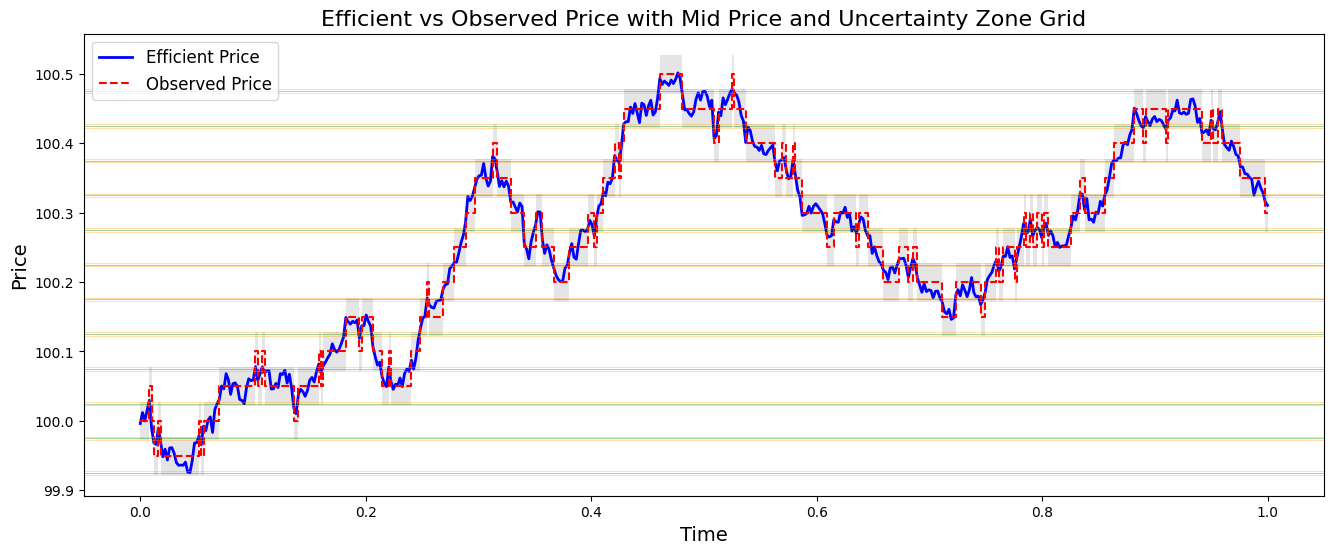

In [6]:
plot_uncertainty_zone_matplotlib(T,n_steps,X0,alpha,eta,sigma)

In [7]:
def plot_uncertainty_zone_seaborn(T,n_steps, X0,alpha, eta,sigma,seed=20030427):
    np.random.seed(seed)
    t, X, P, change_indices = simulate_observed_price(T,n_steps,X0,sigma,alpha,eta)
    # Set seaborn style
    sns.set_style("whitegrid")

    # Initialize plot
    plt.figure(figsize=(16, 6))

    # Plot efficient price and observed price
    sns.lineplot(x=t, y=X, label="Efficient Price", color="blue", linewidth=2)
    sns.lineplot(x=t, y=P, label="Observed Price", color="red", linestyle="--", linewidth=1.5, drawstyle="steps-post")

    # Compute mid prices and uncertainty zone boundaries
    mid_prices = np.zeros_like(X)
    lower_bounds = np.zeros_like(X)
    upper_bounds = np.zeros_like(X)
    shaded_lower = np.full_like(X, np.nan)
    shaded_upper = np.full_like(X, np.nan)

    for i in range(n_steps):
        k = np.round(X[i] / alpha)  # Closest tick level
        mid_prices[i] = (k - 0.5) * alpha  # Mid price between two adjacent ticks
        lower_bounds[i] = mid_prices[i] - alpha * ( eta)
        upper_bounds[i] = mid_prices[i] + alpha * ( eta)

    # Add grid lines at all mid prices, lower, and upper bounds
    all_mid_prices = np.unique(mid_prices)  # Get unique mid price levels
    all_lower_bounds = np.unique(lower_bounds)  # Get unique lower bounds
    all_upper_bounds = np.unique(upper_bounds)  # Get unique upper bounds


    # Draw horizontal grid lines for each level
    for level in all_mid_prices:
        plt.axhline(y=level, color="green", linestyle="-", linewidth=0.5, alpha=0.5)

    for level in all_lower_bounds:
        plt.axhline(y=level, color="orange", linestyle="-", linewidth=0.5, alpha=0.5)

    for level in all_upper_bounds:
        plt.axhline(y=level, color="orange", linestyle="-", linewidth=0.5, alpha=0.5)

    for i in range(len(change_indices) - 1):
        start = change_indices[i]
        end = change_indices[i + 1]
        #mid_price_at_start = mid_prices[start]
        #lower_at_start = mid_price_at_start - alpha * (eta)
        #upper_at_start = mid_price_at_start + alpha * (eta)
        #shaded_lower[start:end] = lower_at_start
        #shaded_upper[start:end] = upper_at_start+alpha

        # Shaded area for uncertainty zones
        #plt.fill_between(t[start:end], lower_at_start, upper_at_start+alpha, color="gray", alpha=0.2)
        #plt.fill_between(t, shaded_lower, shaded_upper, color="lightgray", alpha=0.1)

        # Vertical lines at price change points
        #plt.axvline(x=t[start], color="gray", linestyle=":", linewidth=0.5, alpha=0.5)
        mid_price = mid_prices[start]
        lower = mid_price - alpha * eta
        upper = mid_price + alpha * eta+alpha

        # 填充矩形区域（只填充当前 step）
        plt.fill_between(t[start:end+1], lower, upper, color="gray", alpha=0.2, step="post",edgecolor="none")


    # Labels and title
    plt.xlabel("Time", fontsize=14)
    plt.ylabel("Price", fontsize=14)
    plt.title("Efficient vs Observed Price with Mid Price and Uncertainty Zone Grid", fontsize=16)
    plt.legend(fontsize=12)

    # Show plot
    plt.show()



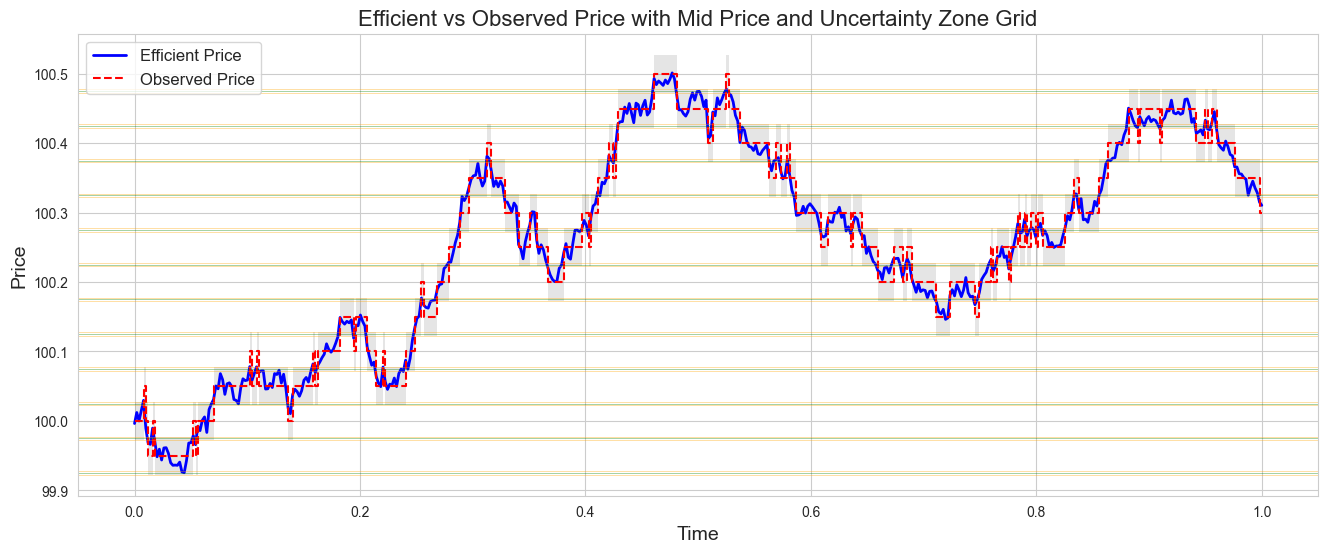

In [8]:
plot_uncertainty_zone_seaborn(T,n_steps,X0,alpha,eta,sigma)

In [9]:
def black_scholes_call(S, K, T, r, sigma):
    """
    Computes the BS price and delta of a European call option.
    """
    if sigma < 0 or T < 0:
        raise ValueError("sigma and T must be greater than zero")
    d1 = (np.log(S)-np.log(K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)

    call_price = S * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)
    delta = norm.cdf(d1)  
    #print(sigma*np.sqrt(T))
    return call_price, delta

In [10]:
def get_optimal_tau(X, alpha, eta):
    tau = [0]
    l = alpha**(-0.5)
    current_zone = (X[0] // alpha) * alpha
    threshold = alpha * (l - 0.5 + eta)
    
    for i in range(1, len(X)):
        upper = current_zone + threshold
        lower = current_zone - threshold
        if X[i] > upper or X[i] < lower:
            tau.append(i)
            current_zone = (X[i] // alpha) * alpha
    return tau


In [11]:
def calculate_hedging_error(t, X, P, tau, K, sigma):
    T = t[-1]
    portfolio = np.zeros(len(tau))
    positions = np.zeros(len(tau))
    
    portfolio[0], positions[0] = black_scholes_call(X[tau[0]], K, T - t[tau[0]],0,sigma)
    
    for j in range(1, len(tau)):
        # 计算时间间隔
        dt = t[tau[j]] - t[tau[j-1]]
        
        # 更新组合价值
        price_change = P[tau[j]] - P[tau[j-1]]
        portfolio[j] = portfolio[j-1] + positions[j-1] * price_change
        
        # 更新对冲头寸
        remaining_T = T - t[tau[j]]
        _, positions[j] = black_scholes_call(X[tau[j]], K, remaining_T,0,sigma)
    
    # 计算最终误差
    final_payoff = max(X[-1] - K, 0)
    return final_payoff - portfolio[-1]


In [12]:
error_1 = np.zeros(number_of_paths)  
error_2 = np.zeros(number_of_paths) 
error_3 = np.zeros(number_of_paths)

In [13]:
def generate_observed_prices(X, tau, alpha):
    """基于退出时间生成观测价格"""
    P = np.zeros_like(X)
    current_p = None
    for i in range(len(X)):
        if i in tau:
            current_p = np.floor(X[i] / alpha) * alpha
        P[i] = current_p if current_p is not None else X[0]
    return P


In [14]:
from tqdm import tqdm
for i in tqdm(range(number_of_paths), desc="Processing Paths"):
        # 生成价格路径
        t, X = simulate_GBM(T, n_steps, X0, sigma)
        
        # 生成固定L观测价格
        _, _, P_fixed, tau_fixed = simulate_observed_price(T, n_steps, X0, sigma, alpha, eta)
        
        # 生成优化L观测价格
        tau_optimal = get_optimal_tau(X, alpha, eta)
        #print(tau_optimal)
        #print(tau_optimal)
        P_optimal = generate_observed_prices(X, tau_optimal, alpha)
        
        error_1[i] = calculate_hedging_error(t, X, X, tau_fixed, K, sigma)
        error_2[i] = calculate_hedging_error(t, X, P_fixed, tau_fixed, K, sigma)
        error_3[i] = calculate_hedging_error(t, X, P_optimal, tau_optimal, K, sigma)

Processing Paths:   0%|          | 0/1000 [00:00<?, ?it/s]/var/folders/9t/9j621j7x7jzc0wvhlbr8tcjh0000gn/T/ipykernel_14895/1116294124.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  d1 = (np.log(S)-np.log(K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))


[0, 60, 199, 467]


Processing Paths:   0%|          | 2/1000 [00:00<03:40,  4.52it/s]

[0, 58, 214]


Processing Paths:   0%|          | 4/1000 [00:00<03:27,  4.80it/s]

[0, 182, 316, 395]
[0, 97]


Processing Paths:   0%|          | 5/1000 [00:01<03:27,  4.79it/s]

[0, 149, 254]
[0, 41, 232]


Processing Paths:   1%|          | 7/1000 [00:01<03:25,  4.84it/s]

[0, 61, 168, 392, 445]
[0, 145, 309, 452]


Processing Paths:   1%|          | 9/1000 [00:01<03:20,  4.94it/s]

[0, 296, 425]
[0, 100, 367, 397]


Processing Paths:   1%|          | 11/1000 [00:02<04:23,  3.75it/s]

[0, 64, 308, 343]
[0, 228, 468]


Processing Paths:   1%|          | 12/1000 [00:02<04:43,  3.49it/s]

[0, 181]


Processing Paths:   1%|▏         | 13/1000 [00:03<04:52,  3.37it/s]

[0, 383, 475]


Processing Paths:   1%|▏         | 14/1000 [00:03<04:57,  3.31it/s]

[0, 197]


Processing Paths:   2%|▏         | 16/1000 [00:03<04:11,  3.91it/s]

[0, 192, 342, 420]
[0, 186, 237, 314, 434, 495]


Processing Paths:   2%|▏         | 19/1000 [00:04<03:39,  4.48it/s]

[0, 305, 383]
[0, 446]


Processing Paths:   2%|▏         | 20/1000 [00:04<03:38,  4.49it/s]

[0, 316]


Processing Paths:   2%|▏         | 21/1000 [00:04<03:35,  4.55it/s]

[0, 48]


Processing Paths:   2%|▏         | 22/1000 [00:05<03:26,  4.74it/s]

[0, 250, 375]
[0, 185]


Processing Paths:   2%|▏         | 24/1000 [00:05<03:26,  4.72it/s]

[0, 147, 209, 383]


Processing Paths:   3%|▎         | 27/1000 [00:06<03:20,  4.85it/s]

[0, 89, 187, 260]
[0, 45, 189, 398]
[0]


Processing Paths:   3%|▎         | 28/1000 [00:06<03:23,  4.79it/s]

[0, 38, 257]
[0, 149, 498]


Processing Paths:   3%|▎         | 30/1000 [00:06<03:24,  4.73it/s]

[0, 43, 157, 336, 418, 453]


Processing Paths:   3%|▎         | 31/1000 [00:07<03:23,  4.76it/s]

[0, 107, 184, 315, 365]


Processing Paths:   3%|▎         | 32/1000 [00:07<03:23,  4.75it/s]

[0, 121, 227, 355, 423, 460]


Processing Paths:   3%|▎         | 33/1000 [00:07<03:22,  4.78it/s]

[0, 166, 266, 436]


Processing Paths:   3%|▎         | 34/1000 [00:07<03:22,  4.77it/s]

[0, 261]


Processing Paths:   4%|▎         | 35/1000 [00:07<03:22,  4.76it/s]

[0]
[0, 252, 456, 497]


Processing Paths:   4%|▎         | 36/1000 [00:08<03:30,  4.59it/s]

[0]


Processing Paths:   4%|▎         | 37/1000 [00:08<03:53,  4.12it/s]

[0, 175, 283, 318]


Processing Paths:   4%|▍         | 38/1000 [00:08<04:10,  3.85it/s]

[0, 49, 113, 427, 454]


Processing Paths:   4%|▍         | 40/1000 [00:09<04:05,  3.90it/s]

[0, 17, 261]


Processing Paths:   4%|▍         | 41/1000 [00:09<03:52,  4.12it/s]

[0, 135, 319, 353]
[0, 367]


Processing Paths:   4%|▍         | 43/1000 [00:09<03:37,  4.40it/s]

[0, 91, 181, 469]


Processing Paths:   4%|▍         | 45/1000 [00:10<03:22,  4.73it/s]

[0, 237, 308]
[0, 55, 339]


Processing Paths:   5%|▍         | 46/1000 [00:10<03:22,  4.72it/s]

[0, 129, 309, 434]
[0, 161]


Processing Paths:   5%|▍         | 48/1000 [00:10<03:26,  4.62it/s]

[0, 207, 268, 387]


Processing Paths:   5%|▌         | 50/1000 [00:11<03:17,  4.80it/s]

[0, 156, 279, 436]
[0, 439, 498]


Processing Paths:   5%|▌         | 51/1000 [00:11<03:19,  4.75it/s]

[0, 177, 307]
[0, 240, 461, 490]


Processing Paths:   5%|▌         | 53/1000 [00:11<03:18,  4.76it/s]

[0, 17, 357]


Processing Paths:   5%|▌         | 54/1000 [00:12<03:19,  4.75it/s]

[0, 94, 492]
[0, 110, 282]


Processing Paths:   6%|▌         | 56/1000 [00:12<03:18,  4.76it/s]

[0, 46, 341, 425]


Processing Paths:   6%|▌         | 57/1000 [00:12<03:17,  4.76it/s]

[0, 81, 192, 388, 445]


Processing Paths:   6%|▌         | 58/1000 [00:12<03:12,  4.90it/s]

[0, 425]
[0, 275, 382]


Processing Paths:   6%|▌         | 60/1000 [00:13<03:18,  4.74it/s]

[0, 56, 328, 394, 453]


Processing Paths:   6%|▌         | 61/1000 [00:13<03:18,  4.73it/s]

[0, 91, 195]
[0, 247, 453]


Processing Paths:   6%|▋         | 63/1000 [00:14<03:19,  4.69it/s]

[0, 164, 344]
[0, 176, 195, 352, 484]


Processing Paths:   6%|▋         | 64/1000 [00:14<03:24,  4.57it/s]

[0, 108, 243, 263]


Processing Paths:   6%|▋         | 65/1000 [00:14<03:54,  3.98it/s]

[0, 82, 206, 487]


Processing Paths:   7%|▋         | 66/1000 [00:15<04:58,  3.12it/s]

[0, 104, 126, 193]


Processing Paths:   7%|▋         | 67/1000 [00:15<04:44,  3.27it/s]

[0, 21]


Processing Paths:   7%|▋         | 68/1000 [00:15<05:36,  2.77it/s]

[0, 182, 380]


Processing Paths:   7%|▋         | 69/1000 [00:16<06:08,  2.53it/s]

[0]


Processing Paths:   7%|▋         | 71/1000 [00:16<05:09,  3.00it/s]

[0, 77]
[0, 359]


Processing Paths:   7%|▋         | 73/1000 [00:17<04:46,  3.24it/s]

[0, 246]
[0, 363]


Processing Paths:   7%|▋         | 74/1000 [00:17<04:44,  3.25it/s]

[0, 277, 338, 396]


Processing Paths:   8%|▊         | 76/1000 [00:18<03:57,  3.90it/s]

[0, 135, 384, 439]
[0, 240, 470]


Processing Paths:   8%|▊         | 78/1000 [00:18<03:56,  3.89it/s]

[0, 39]


Processing Paths:   8%|▊         | 79/1000 [00:18<03:44,  4.10it/s]

[0, 138, 378]
[0, 113, 235, 391]


Processing Paths:   8%|▊         | 81/1000 [00:19<03:45,  4.07it/s]

[0, 59, 320]
[0, 36, 176]


Processing Paths:   8%|▊         | 84/1000 [00:20<03:25,  4.47it/s]

[0, 294, 427]
[0, 184, 309, 415]
[0, 85, 382, 427]


Processing Paths:   9%|▊         | 86/1000 [00:20<03:33,  4.29it/s]

[0, 57, 478]
[0, 302, 380, 498]


Processing Paths:   9%|▊         | 87/1000 [00:20<03:51,  3.95it/s]

[0, 29, 129, 318, 467]


Processing Paths:   9%|▉         | 89/1000 [00:21<03:27,  4.40it/s]

[0, 187, 402]
[0, 394]


Processing Paths:   9%|▉         | 91/1000 [00:21<03:39,  4.14it/s]

[0, 98, 184, 259, 348]


Processing Paths:   9%|▉         | 92/1000 [00:21<03:31,  4.30it/s]

[0, 235]


Processing Paths:   9%|▉         | 93/1000 [00:22<03:31,  4.29it/s]

[0, 106, 336, 377]
[0, 242, 289]


Processing Paths:  10%|▉         | 95/1000 [00:22<03:31,  4.27it/s]

[0, 335, 418]
[0, 74, 108, 496]


Processing Paths:  10%|▉         | 97/1000 [00:23<03:39,  4.12it/s]

[0, 169, 302]


Processing Paths:  10%|▉         | 98/1000 [00:23<03:31,  4.26it/s]

[0, 84, 161, 309, 423]
[0, 205, 281, 313, 444, 478]


Processing Paths:  10%|▉         | 99/1000 [00:23<03:31,  4.25it/s]

[0, 437]


Processing Paths:  10%|█         | 100/1000 [00:23<03:32,  4.23it/s]

[0, 225, 328, 399]


Processing Paths:  10%|█         | 101/1000 [00:24<03:59,  3.75it/s]

[0, 74, 236, 301]


Processing Paths:  10%|█         | 102/1000 [00:24<04:04,  3.67it/s]

[0, 51, 207]


Processing Paths:  10%|█         | 104/1000 [00:25<05:09,  2.90it/s]

[0, 134, 304, 355, 421]


Processing Paths:  10%|█         | 105/1000 [00:25<04:32,  3.28it/s]

[0, 262, 331]


Processing Paths:  11%|█         | 106/1000 [00:25<04:09,  3.59it/s]

[0, 45, 256, 313]


Processing Paths:  11%|█         | 107/1000 [00:26<03:51,  3.86it/s]

[0]
[0, 118, 221, 282, 439]


Processing Paths:  11%|█         | 108/1000 [00:26<05:21,  2.77it/s]

[0, 226, 458]


Processing Paths:  11%|█         | 110/1000 [00:27<04:42,  3.15it/s]

[0, 373, 438]
[0, 40]


Processing Paths:  11%|█         | 111/1000 [00:27<04:31,  3.27it/s]

[0, 231, 392]


Processing Paths:  11%|█▏        | 113/1000 [00:27<03:47,  3.90it/s]

[0, 109, 390]
[0, 69, 143, 353, 476]


Processing Paths:  12%|█▏        | 115/1000 [00:28<03:36,  4.09it/s]

[0, 58, 179, 285, 393]
[0, 26, 250]


Processing Paths:  12%|█▏        | 117/1000 [00:28<03:37,  4.05it/s]

[0, 364, 432]


Processing Paths:  12%|█▏        | 118/1000 [00:29<03:30,  4.19it/s]

[0, 117, 190]


Processing Paths:  12%|█▏        | 119/1000 [00:29<03:15,  4.52it/s]

[0, 384]
[0, 116, 454]


Processing Paths:  12%|█▏        | 120/1000 [00:29<03:18,  4.44it/s]

[0, 499]


Processing Paths:  12%|█▏        | 122/1000 [00:29<03:24,  4.29it/s]

[0, 64, 159]


Processing Paths:  12%|█▏        | 123/1000 [00:30<03:25,  4.26it/s]

[0, 307]
[0, 28, 418]


Processing Paths:  12%|█▎        | 125/1000 [00:30<03:27,  4.21it/s]

[0, 203]
[0, 291]


Processing Paths:  13%|█▎        | 127/1000 [00:31<03:31,  4.14it/s]

[0, 173]


Processing Paths:  13%|█▎        | 128/1000 [00:31<03:26,  4.23it/s]

[0, 115, 224]


Processing Paths:  13%|█▎        | 129/1000 [00:31<03:22,  4.30it/s]

[0, 104, 222, 418]


Processing Paths:  13%|█▎        | 130/1000 [00:31<03:24,  4.25it/s]

[0, 27, 370]


Processing Paths:  13%|█▎        | 131/1000 [00:32<03:21,  4.30it/s]

[0, 80, 182]


Processing Paths:  13%|█▎        | 132/1000 [00:32<03:41,  3.92it/s]

[0, 137, 342]


Processing Paths:  13%|█▎        | 134/1000 [00:32<03:12,  4.50it/s]

[0, 53]
[0, 101, 204, 345]


Processing Paths:  14%|█▎        | 135/1000 [00:32<03:07,  4.62it/s]

[0, 319]
[0, 126, 232, 499]


Processing Paths:  14%|█▎        | 137/1000 [00:33<03:02,  4.74it/s]

[0, 75, 153, 290, 430, 499]


Processing Paths:  14%|█▍        | 139/1000 [00:33<02:55,  4.90it/s]

[0, 81, 336, 396]
[0, 69, 453]


Processing Paths:  14%|█▍        | 140/1000 [00:33<02:54,  4.92it/s]

[0, 39, 289]
[0, 415]


Processing Paths:  14%|█▍        | 142/1000 [00:34<02:58,  4.80it/s]

[0, 325, 425]


Processing Paths:  14%|█▍        | 143/1000 [00:34<02:56,  4.86it/s]

[0, 125, 395]
[0, 111]


Processing Paths:  14%|█▍        | 145/1000 [00:35<03:10,  4.49it/s]

[0, 292, 417]


Processing Paths:  15%|█▍        | 146/1000 [00:35<03:10,  4.47it/s]

[0, 131, 317]
[0]


Processing Paths:  15%|█▍        | 148/1000 [00:35<03:15,  4.37it/s]

[0, 210, 342]


Processing Paths:  15%|█▍        | 149/1000 [00:36<03:09,  4.50it/s]

[0, 112, 251]


Processing Paths:  15%|█▌        | 150/1000 [00:36<03:35,  3.94it/s]

[0, 71, 348]


Processing Paths:  15%|█▌        | 151/1000 [00:36<03:23,  4.16it/s]

[0, 149, 347, 489]
[0]


Processing Paths:  15%|█▌        | 153/1000 [00:36<03:14,  4.35it/s]

[0, 158, 344, 456]


Processing Paths:  15%|█▌        | 154/1000 [00:37<03:09,  4.46it/s]

[0, 353, 458]
[0, 112, 489]


Processing Paths:  16%|█▌        | 156/1000 [00:37<03:05,  4.55it/s]

[0, 272, 328, 463]


Processing Paths:  16%|█▌        | 158/1000 [00:38<02:54,  4.83it/s]

[0, 281, 325]
[0, 195, 291, 479]


Processing Paths:  16%|█▌        | 159/1000 [00:38<02:54,  4.82it/s]

[0, 238, 446]
[0, 194, 257, 459]


Processing Paths:  16%|█▌        | 160/1000 [00:38<03:00,  4.66it/s]

[0, 29, 468]


Processing Paths:  16%|█▌        | 162/1000 [00:38<03:22,  4.14it/s]

[0]


Processing Paths:  16%|█▋        | 163/1000 [00:39<03:21,  4.16it/s]

[0, 254, 445]


Processing Paths:  16%|█▋        | 164/1000 [00:39<03:09,  4.40it/s]

[0, 220]
[0, 197, 293, 394]


Processing Paths:  17%|█▋        | 166/1000 [00:39<03:03,  4.55it/s]

[0, 181, 330]
[0, 163, 415]


Processing Paths:  17%|█▋        | 167/1000 [00:40<03:00,  4.62it/s]

[0, 488]


Processing Paths:  17%|█▋        | 169/1000 [00:40<03:10,  4.37it/s]

[0, 80]


Processing Paths:  17%|█▋        | 170/1000 [00:40<03:08,  4.41it/s]

[0, 285]


Processing Paths:  17%|█▋        | 171/1000 [00:41<03:08,  4.40it/s]

[0, 50, 395]


Processing Paths:  17%|█▋        | 172/1000 [00:41<03:08,  4.40it/s]

[0, 124, 276, 444]
[0, 220, 427]


Processing Paths:  17%|█▋        | 174/1000 [00:41<03:03,  4.49it/s]

[0, 97, 374, 489]
[0, 203, 329, 453]


Processing Paths:  18%|█▊        | 176/1000 [00:42<03:03,  4.50it/s]

[0, 171, 354, 423]


Processing Paths:  18%|█▊        | 177/1000 [00:42<03:03,  4.49it/s]

[0]
[0]


Processing Paths:  18%|█▊        | 179/1000 [00:42<03:10,  4.32it/s]

[0, 220, 467]
[0, 40, 82, 428]


Processing Paths:  18%|█▊        | 182/1000 [00:43<02:51,  4.77it/s]

[0, 158]
[0, 248, 480]


Processing Paths:  18%|█▊        | 183/1000 [00:43<02:51,  4.77it/s]

[0, 53, 90, 164]


Processing Paths:  18%|█▊        | 185/1000 [00:44<02:43,  4.99it/s]

[0, 109, 339]
[0, 67, 121, 183, 246, 312, 396]


Processing Paths:  19%|█▊        | 186/1000 [00:44<03:00,  4.52it/s]

[0, 186, 432, 480]


Processing Paths:  19%|█▊        | 187/1000 [00:44<02:57,  4.59it/s]

[0, 59, 278, 487]


Processing Paths:  19%|█▉        | 188/1000 [00:44<02:55,  4.63it/s]

[0, 213, 268, 380]
[0, 388]


Processing Paths:  19%|█▉        | 190/1000 [00:45<03:06,  4.34it/s]

[0]


Processing Paths:  19%|█▉        | 191/1000 [00:45<02:59,  4.50it/s]

[0, 169]
[0, 86, 423]


Processing Paths:  19%|█▉        | 193/1000 [00:45<02:49,  4.76it/s]

[0]
[0]


Processing Paths:  20%|█▉        | 195/1000 [00:46<02:52,  4.67it/s]

[0, 370]


Processing Paths:  20%|█▉        | 196/1000 [00:46<02:55,  4.57it/s]

[0, 55, 108, 311, 498]


Processing Paths:  20%|█▉        | 198/1000 [00:46<02:56,  4.55it/s]

[0, 327, 402]
[0, 29, 215, 270]


Processing Paths:  20%|█▉        | 199/1000 [00:47<02:59,  4.47it/s]

[0, 97, 358, 495]
[0, 29, 254]


Processing Paths:  20%|██        | 201/1000 [00:47<03:02,  4.38it/s]

[0, 255, 337]


Processing Paths:  20%|██        | 202/1000 [00:47<02:54,  4.58it/s]

[0, 422]
[0, 150, 181, 369, 498]


Processing Paths:  20%|██        | 204/1000 [00:48<03:21,  3.95it/s]

[0, 124, 220, 340]
[0, 197]


Processing Paths:  21%|██        | 206/1000 [00:48<03:02,  4.36it/s]

[0, 71, 130, 190]


Processing Paths:  21%|██        | 207/1000 [00:48<02:58,  4.44it/s]

[0, 91, 254, 279]


Processing Paths:  21%|██        | 208/1000 [00:49<03:01,  4.36it/s]

[0, 98, 483]


Processing Paths:  21%|██        | 209/1000 [00:49<02:59,  4.41it/s]

[0, 181, 342, 401]


Processing Paths:  21%|██        | 210/1000 [00:49<02:53,  4.54it/s]

[0, 313, 363]


Processing Paths:  21%|██        | 211/1000 [00:49<02:45,  4.76it/s]

[0, 309, 469]
[0, 67]


Processing Paths:  21%|██▏       | 213/1000 [00:50<02:47,  4.69it/s]

[0, 64]


Processing Paths:  22%|██▏       | 215/1000 [00:50<02:44,  4.77it/s]

[0, 228, 401]
[0, 203, 320, 399]


Processing Paths:  22%|██▏       | 216/1000 [00:50<02:48,  4.65it/s]

[0, 244, 429, 460]


Processing Paths:  22%|██▏       | 217/1000 [00:51<02:49,  4.61it/s]

[0, 12, 212, 418]
[0, 387, 432, 495]


Processing Paths:  22%|██▏       | 219/1000 [00:51<02:48,  4.63it/s]

[0, 417]


Processing Paths:  22%|██▏       | 220/1000 [00:51<02:46,  4.69it/s]

[0]


Processing Paths:  22%|██▏       | 221/1000 [00:51<02:46,  4.68it/s]

[0, 78]


Processing Paths:  22%|██▏       | 222/1000 [00:52<02:58,  4.36it/s]

[0, 166, 388]


Processing Paths:  22%|██▏       | 223/1000 [00:52<02:52,  4.51it/s]

[0, 33, 84, 239, 367]


Processing Paths:  22%|██▏       | 224/1000 [00:52<02:46,  4.65it/s]

[0]
[0, 136]


Processing Paths:  23%|██▎       | 226/1000 [00:53<02:40,  4.81it/s]

[0, 197, 366, 479]


Processing Paths:  23%|██▎       | 228/1000 [00:53<02:35,  4.96it/s]

[0, 126, 260]
[0]


Processing Paths:  23%|██▎       | 230/1000 [00:53<02:39,  4.84it/s]

[0, 343]
[0, 105, 335]


Processing Paths:  23%|██▎       | 231/1000 [00:54<02:37,  4.89it/s]

[0, 91, 179, 453]
[0, 156, 374]


Processing Paths:  23%|██▎       | 233/1000 [00:54<02:35,  4.92it/s]

[0, 288, 433]
[0]


Processing Paths:  24%|██▎       | 235/1000 [00:54<02:34,  4.96it/s]

[0, 155, 330]
[0, 144, 192, 429, 481]


Processing Paths:  24%|██▎       | 237/1000 [00:55<02:34,  4.95it/s]

[0, 417]


Processing Paths:  24%|██▍       | 239/1000 [00:55<02:27,  5.17it/s]

[0]
[0, 99, 173, 336, 388]
[0, 278, 341]


Processing Paths:  24%|██▍       | 241/1000 [00:56<02:30,  5.04it/s]

[0, 56, 98]


Processing Paths:  24%|██▍       | 242/1000 [00:56<02:49,  4.47it/s]

[0, 243, 406]


Processing Paths:  24%|██▍       | 243/1000 [00:56<02:44,  4.61it/s]

[0, 189, 493]
[0, 35, 92, 377, 421]


Processing Paths:  24%|██▍       | 245/1000 [00:56<02:39,  4.74it/s]

[0, 160, 445]


Processing Paths:  25%|██▍       | 246/1000 [00:57<02:32,  4.95it/s]

[0, 24, 472]
[0, 166, 245]


Processing Paths:  25%|██▍       | 248/1000 [00:57<02:34,  4.88it/s]

[0, 486]


Processing Paths:  25%|██▍       | 249/1000 [00:57<02:35,  4.84it/s]

[0]
[0, 81, 321]


Processing Paths:  25%|██▌       | 252/1000 [00:58<02:29,  4.99it/s]

[0, 344, 483]
[0, 72, 198, 315, 415, 491]


Processing Paths:  25%|██▌       | 254/1000 [00:58<02:25,  5.13it/s]

[0, 121, 387]
[0, 352, 401]


Processing Paths:  26%|██▌       | 255/1000 [00:58<02:28,  5.02it/s]

[0, 312]


Processing Paths:  26%|██▌       | 256/1000 [00:59<02:30,  4.94it/s]

[0, 250, 306, 354, 430]


Processing Paths:  26%|██▌       | 258/1000 [00:59<02:27,  5.03it/s]

[0, 474]
[0, 214, 410]


Processing Paths:  26%|██▌       | 259/1000 [00:59<02:27,  5.02it/s]

[0]
[0, 380]


Processing Paths:  26%|██▌       | 261/1000 [01:00<02:40,  4.61it/s]

[0, 60, 353]


Processing Paths:  26%|██▌       | 262/1000 [01:00<02:36,  4.70it/s]

[0, 67, 278, 362, 495]
[0, 37, 211, 429]


Processing Paths:  26%|██▋       | 264/1000 [01:00<02:31,  4.87it/s]

[0, 53, 218, 409]
[0, 139, 344]


Processing Paths:  27%|██▋       | 266/1000 [01:01<02:31,  4.84it/s]

[0, 242, 275]


Processing Paths:  27%|██▋       | 269/1000 [01:01<02:26,  5.00it/s]

[0, 160, 311, 425, 498]
[0, 111, 138, 336]
[0, 322]


Processing Paths:  27%|██▋       | 270/1000 [01:02<02:25,  5.00it/s]

[0, 238, 340, 398, 476]
[0, 120, 203, 264, 484]


Processing Paths:  27%|██▋       | 272/1000 [01:02<02:27,  4.93it/s]

[0, 70, 375, 432]
[0, 429]


Processing Paths:  27%|██▋       | 274/1000 [01:02<02:37,  4.62it/s]

[0, 196, 233]
[0, 111, 488]


Processing Paths:  28%|██▊       | 276/1000 [01:03<02:36,  4.63it/s]

[0, 165]
[0, 258]


Processing Paths:  28%|██▊       | 279/1000 [01:03<02:30,  4.80it/s]

[0, 237, 416]
[0, 60]


Processing Paths:  28%|██▊       | 280/1000 [01:04<02:34,  4.67it/s]

[0, 57, 171, 311, 347, 407]


Processing Paths:  28%|██▊       | 281/1000 [01:04<02:39,  4.51it/s]

[0, 263]
[0, 48, 141, 200, 441]


Processing Paths:  28%|██▊       | 283/1000 [01:04<02:50,  4.19it/s]

[0, 82, 227, 470]
[0]


Processing Paths:  28%|██▊       | 284/1000 [01:05<02:45,  4.33it/s]

[0, 158]


Processing Paths:  28%|██▊       | 285/1000 [01:05<02:45,  4.32it/s]

[0, 47, 94, 131, 173, 227, 274, 363]


Processing Paths:  29%|██▊       | 287/1000 [01:05<02:47,  4.26it/s]

[0, 407]
[0, 141, 366]


Processing Paths:  29%|██▉       | 288/1000 [01:06<02:47,  4.25it/s]

[0, 67, 343]


Processing Paths:  29%|██▉       | 291/1000 [01:06<02:44,  4.32it/s]

[0, 201]
[0, 125, 225, 326, 415]
[0, 132]


Processing Paths:  29%|██▉       | 293/1000 [01:07<02:35,  4.55it/s]

[0]


Processing Paths:  30%|██▉       | 295/1000 [01:07<02:29,  4.71it/s]

[0, 441]
[0, 56, 193, 304, 440]


Processing Paths:  30%|██▉       | 297/1000 [01:08<02:25,  4.83it/s]

[0, 219, 261, 436, 487]
[0, 317]


Processing Paths:  30%|██▉       | 298/1000 [01:08<02:25,  4.84it/s]

[0, 47, 96, 157, 447]
[0, 84, 346]


Processing Paths:  30%|███       | 300/1000 [01:08<02:25,  4.83it/s]

[0, 190]
[0, 156]


Processing Paths:  30%|███       | 301/1000 [01:08<02:28,  4.71it/s]

[0, 155, 236, 316]


Processing Paths:  30%|███       | 303/1000 [01:09<02:39,  4.36it/s]

[0, 487]
[0, 363]


Processing Paths:  30%|███       | 305/1000 [01:09<02:45,  4.21it/s]

[0, 87, 379, 410]


Processing Paths:  31%|███       | 307/1000 [01:10<02:27,  4.69it/s]

[0, 71]
[0, 332, 364, 498]


Processing Paths:  31%|███       | 308/1000 [01:10<02:26,  4.72it/s]

[0, 352, 438, 486]
[0, 223, 462]


Processing Paths:  31%|███       | 311/1000 [01:11<02:19,  4.93it/s]

[0, 255, 448]
[0, 63, 97, 451]


Processing Paths:  31%|███       | 312/1000 [01:11<02:28,  4.64it/s]

[0, 498]
[0, 86, 290]


Processing Paths:  32%|███▏      | 315/1000 [01:11<02:17,  4.98it/s]

[0]
[0, 138, 297, 411]
[0, 308]


Processing Paths:  32%|███▏      | 317/1000 [01:12<02:25,  4.71it/s]

[0, 200]
[0, 71, 164, 216, 489]


Processing Paths:  32%|███▏      | 320/1000 [01:12<02:16,  4.99it/s]

[0]
[0, 242, 411]


Processing Paths:  32%|███▏      | 321/1000 [01:13<02:16,  4.96it/s]

[0, 204, 335, 460]
[0, 188, 278]


Processing Paths:  32%|███▏      | 323/1000 [01:13<02:38,  4.27it/s]

[0, 151, 193]


Processing Paths:  32%|███▏      | 324/1000 [01:13<02:32,  4.43it/s]

[0, 320, 422]


Processing Paths:  33%|███▎      | 326/1000 [01:14<02:36,  4.30it/s]

[0, 97, 184, 365, 471]
[0, 293]


Processing Paths:  33%|███▎      | 327/1000 [01:14<02:35,  4.32it/s]

[0, 254, 383]


Processing Paths:  33%|███▎      | 328/1000 [01:14<02:30,  4.46it/s]

[0, 201, 474]
[0, 46, 80, 283, 332, 411]


Processing Paths:  33%|███▎      | 331/1000 [01:15<02:16,  4.90it/s]

[0, 278, 496]
[0, 170, 420]


Processing Paths:  33%|███▎      | 332/1000 [01:15<02:17,  4.86it/s]

[0, 352]
[0, 378, 437]


Processing Paths:  33%|███▎      | 334/1000 [01:15<02:15,  4.91it/s]

[0, 65, 243, 486]
[0, 137, 256, 350, 402, 475]


Processing Paths:  34%|███▎      | 337/1000 [01:16<02:13,  4.98it/s]

[0, 145, 216, 452]
[0]


Processing Paths:  34%|███▍      | 338/1000 [01:16<02:16,  4.87it/s]

[0, 88, 158, 460]
[0, 214, 360]


Processing Paths:  34%|███▍      | 339/1000 [01:17<02:17,  4.82it/s]

[0, 70, 143, 310]


Processing Paths:  34%|███▍      | 341/1000 [01:17<02:20,  4.70it/s]

[0, 154, 424]


Processing Paths:  34%|███▍      | 342/1000 [01:17<02:13,  4.94it/s]

[0, 80, 126, 159, 345]
[0, 386]


Processing Paths:  35%|███▍      | 346/1000 [01:18<02:41,  4.06it/s]

[0, 70, 279]
[0, 113]
[0, 77, 240, 336]


Processing Paths:  35%|███▍      | 347/1000 [01:19<02:46,  3.93it/s]

[0, 54, 165]
[0, 40, 215, 372]


Processing Paths:  35%|███▍      | 348/1000 [01:19<03:14,  3.35it/s]

[0, 281]


Processing Paths:  35%|███▌      | 350/1000 [01:20<03:12,  3.38it/s]

[0, 64, 261, 279, 319]


Processing Paths:  35%|███▌      | 351/1000 [01:20<02:49,  3.82it/s]

[0, 126, 408]
[0, 168, 227]


Processing Paths:  36%|███▌      | 355/1000 [01:21<02:16,  4.72it/s]

[0, 43]
[0]
[0]


Processing Paths:  36%|███▌      | 356/1000 [01:21<02:20,  4.58it/s]

[0, 102, 404]
[0, 33, 254, 345, 493]


Processing Paths:  36%|███▌      | 358/1000 [01:21<02:22,  4.50it/s]

[0, 317, 380]


Processing Paths:  36%|███▌      | 359/1000 [01:22<02:43,  3.91it/s]

[0, 68, 377]


Processing Paths:  36%|███▌      | 360/1000 [01:22<02:28,  4.30it/s]

[0, 201, 240, 410]
[0, 35, 296]


Processing Paths:  36%|███▌      | 362/1000 [01:22<02:24,  4.43it/s]

[0, 315]


Processing Paths:  36%|███▋      | 365/1000 [01:23<02:10,  4.88it/s]

[0, 288]
[0, 82, 161, 285, 369, 472]
[0, 240, 348]


Processing Paths:  37%|███▋      | 366/1000 [01:23<02:10,  4.85it/s]

[0, 359]


Processing Paths:  37%|███▋      | 367/1000 [01:23<02:12,  4.79it/s]

[0, 55, 261, 288]
[0, 233, 328, 428]


Processing Paths:  37%|███▋      | 368/1000 [01:23<02:13,  4.75it/s]

[0]


Processing Paths:  37%|███▋      | 370/1000 [01:24<02:48,  3.74it/s]

[0]
[0, 108, 216, 466]


Processing Paths:  37%|███▋      | 371/1000 [01:25<05:26,  1.93it/s]

[0]


Processing Paths:  37%|███▋      | 372/1000 [01:26<05:14,  2.00it/s]

[0, 185, 271, 338]


Processing Paths:  37%|███▋      | 374/1000 [01:26<04:12,  2.48it/s]

[0, 432]


Processing Paths:  38%|███▊      | 375/1000 [01:27<03:46,  2.76it/s]

[0, 232, 300, 477]


Processing Paths:  38%|███▊      | 376/1000 [01:27<03:27,  3.01it/s]

[0, 442]


Processing Paths:  38%|███▊      | 377/1000 [01:27<03:14,  3.20it/s]

[0, 280, 337]


Processing Paths:  38%|███▊      | 378/1000 [01:27<02:57,  3.50it/s]

[0, 41, 341]
[0, 146, 369, 467]


Processing Paths:  38%|███▊      | 380/1000 [01:28<02:55,  3.54it/s]

[0, 452]
[0, 67, 374]


Processing Paths:  38%|███▊      | 381/1000 [01:28<02:57,  3.49it/s]

[0]


Processing Paths:  38%|███▊      | 382/1000 [01:29<03:02,  3.39it/s]

[0, 31, 136, 383, 443]


Processing Paths:  38%|███▊      | 383/1000 [01:29<03:03,  3.36it/s]

[0, 408]


Processing Paths:  38%|███▊      | 384/1000 [01:29<02:59,  3.43it/s]

[0, 93, 448, 497]


Processing Paths:  39%|███▊      | 386/1000 [01:30<02:44,  3.73it/s]

[0, 277, 497]


Processing Paths:  39%|███▊      | 387/1000 [01:30<02:34,  3.98it/s]

[0, 328, 405, 474]


Processing Paths:  39%|███▉      | 388/1000 [01:30<02:23,  4.28it/s]

[0, 85, 134, 479]
[0, 337, 352, 447]


Processing Paths:  39%|███▉      | 389/1000 [01:30<02:27,  4.15it/s]

[0]


Processing Paths:  39%|███▉      | 392/1000 [01:31<02:10,  4.65it/s]

[0]
[0, 309, 435]


Processing Paths:  39%|███▉      | 393/1000 [01:31<02:16,  4.45it/s]

[0, 176, 377]
[0, 183]


Processing Paths:  40%|███▉      | 395/1000 [01:32<02:23,  4.21it/s]

[0, 74, 455]
[0, 68, 200, 322]


Processing Paths:  40%|███▉      | 396/1000 [01:32<02:21,  4.27it/s]

[0, 141, 341]


Processing Paths:  40%|███▉      | 398/1000 [01:32<02:23,  4.18it/s]

[0, 451]


Processing Paths:  40%|███▉      | 399/1000 [01:33<02:19,  4.31it/s]

[0, 108]
[0, 370]


Processing Paths:  40%|████      | 401/1000 [01:33<02:19,  4.29it/s]

[0, 145, 383]
[0, 167, 221, 428, 465]


Processing Paths:  40%|████      | 402/1000 [01:33<02:38,  3.78it/s]

[0, 268]


Processing Paths:  40%|████      | 403/1000 [01:34<02:35,  3.84it/s]

[0, 126, 210, 326]


Processing Paths:  40%|████      | 404/1000 [01:34<02:31,  3.94it/s]

[0, 142, 225, 456]


Processing Paths:  40%|████      | 405/1000 [01:34<02:30,  3.96it/s]

[0, 44, 447]


Processing Paths:  41%|████      | 407/1000 [01:35<02:28,  3.99it/s]

[0, 457]


Processing Paths:  41%|████      | 408/1000 [01:35<02:24,  4.11it/s]

[0, 56, 136]


Processing Paths:  41%|████      | 409/1000 [01:35<02:27,  4.02it/s]

[0, 35, 145, 305, 472]
[0, 202, 270, 334]


Processing Paths:  41%|████      | 410/1000 [01:35<02:32,  3.86it/s]

[0, 261]


Processing Paths:  41%|████      | 411/1000 [01:36<02:32,  3.86it/s]

[0, 223, 464]


Processing Paths:  41%|████      | 412/1000 [01:36<02:32,  3.85it/s]

[0, 78, 156, 222, 260]


Processing Paths:  41%|████▏     | 413/1000 [01:36<02:37,  3.74it/s]

[0, 54]


Processing Paths:  41%|████▏     | 414/1000 [01:37<02:49,  3.46it/s]

[0, 41, 168, 236]


Processing Paths:  42%|████▏     | 415/1000 [01:37<03:02,  3.21it/s]

[0, 243]


Processing Paths:  42%|████▏     | 416/1000 [01:37<03:19,  2.92it/s]

[0, 50, 124, 257]


Processing Paths:  42%|████▏     | 417/1000 [01:38<03:20,  2.91it/s]

[0, 181, 238]


Processing Paths:  42%|████▏     | 418/1000 [01:38<03:13,  3.00it/s]

[0, 146, 414]


Processing Paths:  42%|████▏     | 419/1000 [01:38<03:29,  2.78it/s]

[0, 178]


Processing Paths:  42%|████▏     | 420/1000 [01:39<03:16,  2.95it/s]

[0, 109, 195]


Processing Paths:  42%|████▏     | 422/1000 [01:39<03:03,  3.14it/s]

[0, 261, 400]
[0, 119, 323, 421]


Processing Paths:  42%|████▏     | 423/1000 [01:40<03:43,  2.58it/s]

[0, 203, 377]


Processing Paths:  42%|████▏     | 424/1000 [01:40<04:11,  2.29it/s]

[0, 417]


Processing Paths:  43%|████▎     | 426/1000 [01:41<03:19,  2.88it/s]

[0, 106, 224, 268, 406, 469]
[0, 157, 441, 499]


Processing Paths:  43%|████▎     | 428/1000 [01:41<02:39,  3.58it/s]

[0, 217, 393]
[0, 303, 369]


Processing Paths:  43%|████▎     | 430/1000 [01:42<02:26,  3.90it/s]

[0]


Processing Paths:  43%|████▎     | 431/1000 [01:42<02:17,  4.15it/s]

[0, 57, 456]


Processing Paths:  43%|████▎     | 432/1000 [01:42<02:10,  4.34it/s]

[0, 25]
[0, 63, 97, 131]


Processing Paths:  43%|████▎     | 434/1000 [01:43<02:02,  4.64it/s]

[0, 97, 290, 336]
[0, 278]


Processing Paths:  44%|████▎     | 436/1000 [01:43<01:59,  4.73it/s]

[0, 220]


Processing Paths:  44%|████▎     | 437/1000 [01:43<01:58,  4.77it/s]

[0, 50, 273]


Processing Paths:  44%|████▍     | 439/1000 [01:44<01:52,  4.99it/s]

[0, 301]
[0, 233, 393]


Processing Paths:  44%|████▍     | 440/1000 [01:44<01:51,  5.02it/s]

[0, 162]
[0, 37, 444]


Processing Paths:  44%|████▍     | 442/1000 [01:44<01:49,  5.08it/s]

[0, 198]
[0, 106, 156, 390]


Processing Paths:  44%|████▍     | 444/1000 [01:45<02:05,  4.43it/s]

[0, 187, 439]
[0, 365]


Processing Paths:  44%|████▍     | 445/1000 [01:45<02:40,  3.45it/s]

[0, 102, 293, 400]


Processing Paths:  45%|████▍     | 447/1000 [01:46<02:23,  3.86it/s]

[0, 36, 194]
[0, 34, 491]


Processing Paths:  45%|████▍     | 449/1000 [01:46<02:19,  3.94it/s]

[0]
[0, 56]


Processing Paths:  45%|████▌     | 452/1000 [01:47<02:01,  4.50it/s]

[0, 171]
[0, 200, 287, 471]
[0, 241]


Processing Paths:  45%|████▌     | 454/1000 [01:47<02:04,  4.38it/s]

[0, 147]
[0, 54, 265, 444]


Processing Paths:  46%|████▌     | 456/1000 [01:48<01:57,  4.61it/s]

[0, 88, 322]


Processing Paths:  46%|████▌     | 458/1000 [01:48<01:51,  4.86it/s]

[0, 59, 402]
[0, 94, 213, 410]
[0]


Processing Paths:  46%|████▌     | 460/1000 [01:48<01:52,  4.80it/s]

[0, 72, 358, 440]


Processing Paths:  46%|████▌     | 461/1000 [01:49<01:52,  4.79it/s]

[0, 174, 298]


Processing Paths:  46%|████▌     | 462/1000 [01:49<01:50,  4.89it/s]

[0, 203]
[0, 76, 149]


Processing Paths:  46%|████▋     | 464/1000 [01:49<01:51,  4.79it/s]

[0, 32, 279, 327, 486]


Processing Paths:  46%|████▋     | 465/1000 [01:49<01:50,  4.86it/s]

[0, 194, 371, 465]
[0, 88, 338]


Processing Paths:  47%|████▋     | 468/1000 [01:50<01:48,  4.90it/s]

[0, 200, 274]
[0, 40, 94, 192]


Processing Paths:  47%|████▋     | 469/1000 [01:50<01:51,  4.76it/s]

[0, 339, 489]


Processing Paths:  47%|████▋     | 470/1000 [01:51<01:51,  4.74it/s]

[0]


Processing Paths:  47%|████▋     | 471/1000 [01:51<01:51,  4.73it/s]

[0, 236, 336, 409]


Processing Paths:  47%|████▋     | 472/1000 [01:51<01:51,  4.74it/s]

[0, 54]


Processing Paths:  48%|████▊     | 475/1000 [01:52<01:45,  4.98it/s]

[0, 398, 479]
[0, 61, 155, 215, 237, 324]
[0, 104, 148, 338, 463]


Processing Paths:  48%|████▊     | 476/1000 [01:52<01:46,  4.93it/s]

[0, 85, 243, 327, 393, 430]
[0, 371, 476]


Processing Paths:  48%|████▊     | 478/1000 [01:52<01:47,  4.85it/s]

[0, 450]


Processing Paths:  48%|████▊     | 479/1000 [01:52<01:46,  4.88it/s]

[0, 164, 352]
[0]


Processing Paths:  48%|████▊     | 482/1000 [01:53<01:45,  4.93it/s]

[0, 420]
[0, 40, 165, 269, 336]
[0, 261, 382]


Processing Paths:  48%|████▊     | 483/1000 [01:53<01:50,  4.70it/s]

[0, 217, 361]


Processing Paths:  48%|████▊     | 485/1000 [01:54<01:56,  4.44it/s]

[0, 262, 331]


Processing Paths:  49%|████▊     | 486/1000 [01:54<01:52,  4.55it/s]

[0, 301]


Processing Paths:  49%|████▊     | 487/1000 [01:54<01:51,  4.60it/s]

[0, 180, 324]
[0, 97, 233, 362, 499]


Processing Paths:  49%|████▉     | 490/1000 [01:55<01:45,  4.85it/s]

[0, 188, 253, 349, 390]
[0, 366]


Processing Paths:  49%|████▉     | 491/1000 [01:55<01:45,  4.82it/s]

[0, 136, 212, 360, 453, 472]


Processing Paths:  49%|████▉     | 493/1000 [01:55<01:45,  4.82it/s]

[0, 486]
[0, 183]


Processing Paths:  49%|████▉     | 494/1000 [01:56<01:45,  4.81it/s]

[0, 136]
[0, 47, 133]


Processing Paths:  50%|████▉     | 495/1000 [01:56<01:45,  4.81it/s]

[0, 90, 308, 499]


Processing Paths:  50%|████▉     | 497/1000 [01:56<01:45,  4.75it/s]

[0, 118, 401]
[0, 84]


Processing Paths:  50%|████▉     | 499/1000 [01:57<01:45,  4.77it/s]

[0, 333]


Processing Paths:  50%|█████     | 500/1000 [01:57<01:45,  4.73it/s]

[0, 235, 374]


Processing Paths:  50%|█████     | 501/1000 [01:57<01:44,  4.78it/s]

[0, 345, 453]


Processing Paths:  50%|█████     | 502/1000 [01:57<01:44,  4.76it/s]

[0, 102]
[0, 15]


Processing Paths:  50%|█████     | 504/1000 [01:58<01:44,  4.76it/s]

[0, 189, 426, 463]


Processing Paths:  51%|█████     | 506/1000 [01:58<01:41,  4.85it/s]

[0, 63, 254, 498]
[0, 160, 446]


Processing Paths:  51%|█████     | 507/1000 [01:58<01:41,  4.84it/s]

[0]
[0, 62, 244, 316, 400]


Processing Paths:  51%|█████     | 509/1000 [01:59<01:43,  4.74it/s]

[0, 34, 91, 148, 239, 358, 499]


Processing Paths:  51%|█████     | 510/1000 [01:59<01:42,  4.76it/s]

[0, 55, 445]


Processing Paths:  51%|█████     | 511/1000 [01:59<01:43,  4.74it/s]

[0, 184]


Processing Paths:  51%|█████▏    | 513/1000 [02:00<01:39,  4.88it/s]

[0, 48, 261]
[0, 43, 446]


Processing Paths:  51%|█████▏    | 514/1000 [02:00<01:41,  4.79it/s]

[0, 416]
[0, 145, 254, 349, 498]


Processing Paths:  52%|█████▏    | 516/1000 [02:00<01:58,  4.08it/s]

[0, 54]


Processing Paths:  52%|█████▏    | 517/1000 [02:01<01:55,  4.20it/s]

[0, 112, 213]


Processing Paths:  52%|█████▏    | 518/1000 [02:01<01:50,  4.36it/s]

[0, 319, 411, 459]


Processing Paths:  52%|█████▏    | 519/1000 [02:01<01:48,  4.44it/s]

[0, 425]


Processing Paths:  52%|█████▏    | 520/1000 [02:01<01:46,  4.49it/s]

[0, 260, 483]


Processing Paths:  52%|█████▏    | 522/1000 [02:02<01:41,  4.73it/s]

[0, 94]
[0, 165, 475]


Processing Paths:  52%|█████▏    | 523/1000 [02:02<01:41,  4.71it/s]

[0, 180, 474]


Processing Paths:  52%|█████▏    | 524/1000 [02:02<01:36,  4.93it/s]

[0, 260, 381]
[0, 142, 318]


Processing Paths:  53%|█████▎    | 526/1000 [02:02<01:34,  5.02it/s]

[0, 176, 253, 442]
[0, 116, 310, 426]


Processing Paths:  53%|█████▎    | 527/1000 [02:03<01:35,  4.95it/s]

[0, 291]


Processing Paths:  53%|█████▎    | 529/1000 [02:03<01:36,  4.86it/s]

[0, 403]
[0, 362]


Processing Paths:  53%|█████▎    | 532/1000 [02:04<01:34,  4.97it/s]

[0, 212, 317]
[0, 61, 433]


Processing Paths:  53%|█████▎    | 533/1000 [02:04<01:35,  4.87it/s]

[0, 105, 126, 167]


Processing Paths:  53%|█████▎    | 534/1000 [02:04<01:36,  4.83it/s]

[0, 99, 226]


Processing Paths:  54%|█████▎    | 535/1000 [02:04<01:36,  4.81it/s]

[0, 119, 167, 351]


Processing Paths:  54%|█████▎    | 536/1000 [02:04<01:36,  4.79it/s]

[0, 130]


Processing Paths:  54%|█████▎    | 537/1000 [02:05<01:31,  5.03it/s]

[0, 79, 220, 331, 425]
[0, 117, 217, 381, 441]


Processing Paths:  54%|█████▍    | 540/1000 [02:05<01:33,  4.92it/s]

[0, 142, 211]
[0, 205, 296]


Processing Paths:  54%|█████▍    | 541/1000 [02:05<01:35,  4.79it/s]

[0, 118, 288]
[0, 53, 155, 184, 240, 289]


Processing Paths:  54%|█████▍    | 543/1000 [02:06<01:36,  4.71it/s]

[0, 141, 232]


Processing Paths:  54%|█████▍    | 544/1000 [02:06<01:38,  4.65it/s]

[0, 272]


Processing Paths:  55%|█████▍    | 545/1000 [02:06<01:47,  4.25it/s]

[0, 153, 242]
[0, 307, 345]


Processing Paths:  55%|█████▍    | 547/1000 [02:07<01:44,  4.32it/s]

[0, 84, 158, 194, 346, 468]


Processing Paths:  55%|█████▍    | 548/1000 [02:07<01:42,  4.39it/s]

[0, 236, 323]


Processing Paths:  55%|█████▍    | 549/1000 [02:07<01:41,  4.44it/s]

[0, 161, 349]


Processing Paths:  55%|█████▌    | 550/1000 [02:07<01:38,  4.55it/s]

[0, 204, 342]
[0, 8, 106]


Processing Paths:  55%|█████▌    | 552/1000 [02:08<01:34,  4.76it/s]

[0, 155, 213, 293]
[0, 105]


Processing Paths:  55%|█████▌    | 554/1000 [02:08<01:32,  4.83it/s]

[0, 249]
[0]


Processing Paths:  56%|█████▌    | 557/1000 [02:09<01:30,  4.87it/s]

[0, 64, 205, 436]
[0, 440]


Processing Paths:  56%|█████▌    | 558/1000 [02:09<01:29,  4.94it/s]

[0, 175, 311, 342]
[0, 246, 343]


Processing Paths:  56%|█████▌    | 560/1000 [02:09<01:31,  4.83it/s]

[0, 48, 201, 269, 436]


Processing Paths:  56%|█████▌    | 562/1000 [02:10<01:30,  4.84it/s]

[0, 42, 138, 324]
[0, 268]


Processing Paths:  56%|█████▋    | 563/1000 [02:10<01:31,  4.77it/s]

[0, 312]


Processing Paths:  56%|█████▋    | 564/1000 [02:10<01:31,  4.74it/s]

[0, 26, 328, 459]
[0, 75, 457]


Processing Paths:  57%|█████▋    | 566/1000 [02:11<01:31,  4.73it/s]

[0, 36, 389, 483]


Processing Paths:  57%|█████▋    | 567/1000 [02:11<01:31,  4.71it/s]

[0, 148]


Processing Paths:  57%|█████▋    | 568/1000 [02:11<01:33,  4.64it/s]

[0, 446]


Processing Paths:  57%|█████▋    | 569/1000 [02:11<01:34,  4.57it/s]

[0, 43, 105]


Processing Paths:  57%|█████▋    | 570/1000 [02:12<01:31,  4.68it/s]

[0, 262]
[0, 44]


Processing Paths:  57%|█████▋    | 572/1000 [02:12<01:31,  4.68it/s]

[0, 307]
[0, 211, 270, 425]


Processing Paths:  57%|█████▋    | 573/1000 [02:12<01:31,  4.68it/s]

[0, 320, 362]


Processing Paths:  57%|█████▊    | 575/1000 [02:13<01:39,  4.29it/s]

[0, 175, 271, 461]


Processing Paths:  58%|█████▊    | 576/1000 [02:13<01:32,  4.56it/s]

[0, 251, 345]
[0, 116, 261, 329, 452]


Processing Paths:  58%|█████▊    | 578/1000 [02:13<01:31,  4.62it/s]

[0, 323]


Processing Paths:  58%|█████▊    | 579/1000 [02:14<01:30,  4.64it/s]

[0, 80, 147]
[0, 121, 304]


Processing Paths:  58%|█████▊    | 580/1000 [02:14<01:32,  4.55it/s]

[0, 92, 152, 358]


Processing Paths:  58%|█████▊    | 582/1000 [02:14<01:41,  4.10it/s]

[0, 103, 324, 370]
[0, 431]


Processing Paths:  58%|█████▊    | 583/1000 [02:15<02:14,  3.10it/s]

[0, 184, 336]


Processing Paths:  58%|█████▊    | 584/1000 [02:15<02:34,  2.69it/s]

[0, 169, 221, 424]


Processing Paths:  58%|█████▊    | 585/1000 [02:16<02:55,  2.36it/s]

[0, 188, 432]


Processing Paths:  59%|█████▊    | 586/1000 [02:16<03:04,  2.25it/s]

[0, 40, 126, 224, 262, 432]


Processing Paths:  59%|█████▊    | 587/1000 [02:17<02:51,  2.41it/s]

[0, 45, 160, 218, 333]


Processing Paths:  59%|█████▉    | 588/1000 [02:17<02:47,  2.46it/s]

[0, 268]


Processing Paths:  59%|█████▉    | 589/1000 [02:17<02:36,  2.62it/s]

[0, 70, 170]


Processing Paths:  59%|█████▉    | 591/1000 [02:18<02:22,  2.87it/s]

[0, 417]
[0, 83, 249, 451]


Processing Paths:  59%|█████▉    | 592/1000 [02:18<02:20,  2.90it/s]

[0, 236]


Processing Paths:  59%|█████▉    | 594/1000 [02:19<02:00,  3.38it/s]

[0, 27, 209]


Processing Paths:  60%|█████▉    | 595/1000 [02:19<01:50,  3.66it/s]

[0, 205, 491]
[0, 32, 437]


Processing Paths:  60%|█████▉    | 596/1000 [02:19<01:51,  3.62it/s]

[0, 176]


Processing Paths:  60%|█████▉    | 597/1000 [02:20<01:46,  3.77it/s]

[0, 244, 367, 483]


Processing Paths:  60%|█████▉    | 599/1000 [02:20<01:46,  3.76it/s]

[0, 69]
[0, 149, 356, 399]


Processing Paths:  60%|██████    | 600/1000 [02:20<01:46,  3.75it/s]

[0, 118, 211, 299, 441]


Processing Paths:  60%|██████    | 601/1000 [02:21<01:47,  3.70it/s]

[0, 9, 240, 321]


Processing Paths:  60%|██████    | 602/1000 [02:21<01:58,  3.35it/s]

[0, 96]


Processing Paths:  60%|██████    | 603/1000 [02:21<01:52,  3.53it/s]

[0, 310]


Processing Paths:  60%|██████    | 604/1000 [02:22<01:48,  3.64it/s]

[0, 157, 498]


Processing Paths:  60%|██████    | 605/1000 [02:22<01:51,  3.54it/s]

[0, 60]


Processing Paths:  61%|██████    | 606/1000 [02:22<01:48,  3.64it/s]

[0, 83]


Processing Paths:  61%|██████    | 607/1000 [02:22<01:48,  3.64it/s]

[0]


Processing Paths:  61%|██████    | 608/1000 [02:23<01:56,  3.35it/s]

[0, 467]


Processing Paths:  61%|██████    | 610/1000 [02:23<01:56,  3.35it/s]

[0, 59, 252, 341]
[0]


Processing Paths:  61%|██████    | 611/1000 [02:24<02:17,  2.83it/s]

[0, 304]


Processing Paths:  61%|██████    | 612/1000 [02:24<02:11,  2.95it/s]

[0, 77, 424]


Processing Paths:  61%|██████▏   | 613/1000 [02:25<02:05,  3.09it/s]

[0, 37, 224, 482]


Processing Paths:  61%|██████▏   | 614/1000 [02:25<02:01,  3.17it/s]

[0, 131, 383]


Processing Paths:  62%|██████▏   | 615/1000 [02:25<01:59,  3.21it/s]

[0, 353, 447]


Processing Paths:  62%|██████▏   | 616/1000 [02:25<01:55,  3.33it/s]

[0, 167, 311, 425, 440]


Processing Paths:  62%|██████▏   | 618/1000 [02:26<01:46,  3.60it/s]

[0, 197, 264, 307]


Processing Paths:  62%|██████▏   | 619/1000 [02:26<01:47,  3.54it/s]

[0, 408]
[0, 385, 475]


Processing Paths:  62%|██████▏   | 621/1000 [02:27<01:37,  3.88it/s]

[0, 208, 258]
[0, 117]


Processing Paths:  62%|██████▏   | 623/1000 [02:27<01:28,  4.27it/s]

[0, 57, 372]


Processing Paths:  62%|██████▏   | 624/1000 [02:27<01:24,  4.43it/s]

[0, 84, 452]
[0, 98, 282]


Processing Paths:  63%|██████▎   | 626/1000 [02:28<01:27,  4.26it/s]

[0, 78, 248]


Processing Paths:  63%|██████▎   | 627/1000 [02:28<01:21,  4.59it/s]

[0]
[0, 180, 479]


Processing Paths:  63%|██████▎   | 629/1000 [02:29<01:34,  3.91it/s]

[0, 277]
[0, 343, 442]


Processing Paths:  63%|██████▎   | 631/1000 [02:29<01:37,  3.79it/s]

[0, 138]
[0, 121, 238, 312, 396, 492]


Processing Paths:  63%|██████▎   | 632/1000 [02:29<01:34,  3.90it/s]

[0, 430]


Processing Paths:  63%|██████▎   | 633/1000 [02:30<01:36,  3.81it/s]

[0, 88]


Processing Paths:  63%|██████▎   | 634/1000 [02:30<01:36,  3.79it/s]

[0, 167, 269]


Processing Paths:  64%|██████▎   | 635/1000 [02:30<01:35,  3.81it/s]

[0, 76, 237, 447]


Processing Paths:  64%|██████▎   | 637/1000 [02:31<01:34,  3.86it/s]

[0, 397, 495]
[0, 57, 349]


Processing Paths:  64%|██████▍   | 638/1000 [02:31<01:32,  3.92it/s]

[0, 179, 332, 375]


Processing Paths:  64%|██████▍   | 639/1000 [02:31<01:32,  3.92it/s]

[0, 167, 437]


Processing Paths:  64%|██████▍   | 640/1000 [02:31<01:32,  3.91it/s]

[0, 33, 82, 128, 253, 366, 467]


Processing Paths:  64%|██████▍   | 641/1000 [02:32<01:31,  3.92it/s]

[0, 129, 181]


Processing Paths:  64%|██████▍   | 642/1000 [02:32<01:32,  3.87it/s]

[0, 57, 164, 403]


Processing Paths:  64%|██████▍   | 643/1000 [02:32<01:31,  3.91it/s]

[0, 197, 331, 360, 437]


Processing Paths:  64%|██████▍   | 644/1000 [02:33<01:43,  3.45it/s]

[0, 150, 279, 435]


Processing Paths:  64%|██████▍   | 645/1000 [02:33<02:19,  2.54it/s]

[0, 291]


Processing Paths:  65%|██████▍   | 646/1000 [02:34<02:22,  2.48it/s]

[0, 242, 377, 431]


Processing Paths:  65%|██████▍   | 648/1000 [02:34<02:02,  2.87it/s]

[0, 78, 343]


Processing Paths:  65%|██████▍   | 649/1000 [02:35<01:48,  3.25it/s]

[0, 336]


Processing Paths:  65%|██████▌   | 650/1000 [02:35<01:37,  3.60it/s]

[0, 120, 270]
[0, 387]


Processing Paths:  65%|██████▌   | 651/1000 [02:35<01:44,  3.34it/s]

[0, 105]


Processing Paths:  65%|██████▌   | 652/1000 [02:35<01:44,  3.33it/s]

[0, 314, 498]


Processing Paths:  65%|██████▌   | 653/1000 [02:36<01:40,  3.44it/s]

[0, 113, 205, 410]


Processing Paths:  65%|██████▌   | 654/1000 [02:36<02:08,  2.69it/s]

[0]


Processing Paths:  66%|██████▌   | 655/1000 [02:37<02:11,  2.62it/s]

[0, 43, 155, 267, 308, 356]


Processing Paths:  66%|██████▌   | 656/1000 [02:37<02:00,  2.86it/s]

[0, 131]


Processing Paths:  66%|██████▌   | 658/1000 [02:37<01:43,  3.31it/s]

[0, 128, 174]
[0, 265]


Processing Paths:  66%|██████▌   | 659/1000 [02:38<01:42,  3.34it/s]

[0, 98, 145, 261, 299, 464]


Processing Paths:  66%|██████▌   | 660/1000 [02:38<01:35,  3.57it/s]

[0, 123, 387]


Processing Paths:  66%|██████▌   | 661/1000 [02:38<01:37,  3.47it/s]

[0, 105, 271]


Processing Paths:  66%|██████▋   | 663/1000 [02:39<01:43,  3.26it/s]

[0, 306]
[0, 94]


Processing Paths:  66%|██████▋   | 664/1000 [02:39<01:41,  3.33it/s]

[0, 114, 209, 411, 494]


Processing Paths:  67%|██████▋   | 666/1000 [02:40<01:32,  3.62it/s]

[0, 324, 383]
[0, 130, 376]


Processing Paths:  67%|██████▋   | 668/1000 [02:40<01:24,  3.91it/s]

[0, 59, 350]


Processing Paths:  67%|██████▋   | 669/1000 [02:40<01:19,  4.15it/s]

[0, 181, 274, 481]
[0, 171, 240, 320, 401]


Processing Paths:  67%|██████▋   | 672/1000 [02:41<01:14,  4.40it/s]

[0, 246, 406]
[0, 52, 128, 353]


Processing Paths:  67%|██████▋   | 673/1000 [02:41<01:12,  4.48it/s]

[0, 460]


Processing Paths:  68%|██████▊   | 675/1000 [02:42<01:08,  4.72it/s]

[0, 116, 147, 476]
[0, 87, 153, 446]


Processing Paths:  68%|██████▊   | 676/1000 [02:42<01:07,  4.80it/s]

[0, 29, 283]
[0]


Processing Paths:  68%|██████▊   | 678/1000 [02:42<01:07,  4.75it/s]

[0, 221]


Processing Paths:  68%|██████▊   | 679/1000 [02:42<01:04,  4.94it/s]

[0]
[0, 70, 119, 365]


Processing Paths:  68%|██████▊   | 681/1000 [02:43<01:06,  4.82it/s]

[0, 319, 367]


Processing Paths:  68%|██████▊   | 682/1000 [02:43<01:03,  5.04it/s]

[0, 223]
[0, 99, 165, 344]


Processing Paths:  68%|██████▊   | 684/1000 [02:44<01:05,  4.85it/s]

[0, 134, 334]


Processing Paths:  68%|██████▊   | 685/1000 [02:44<01:05,  4.83it/s]

[0, 405]
[0, 198, 234, 340]


Processing Paths:  69%|██████▊   | 686/1000 [02:44<01:03,  4.91it/s]

[0, 155, 242, 338, 461]


Processing Paths:  69%|██████▉   | 688/1000 [02:44<01:09,  4.51it/s]

[0]
[0, 421]


Processing Paths:  69%|██████▉   | 691/1000 [02:45<01:04,  4.82it/s]

[0, 127, 336]
[0, 119, 379, 461]


Processing Paths:  69%|██████▉   | 692/1000 [02:45<01:04,  4.74it/s]

[0, 37, 336, 498]


Processing Paths:  69%|██████▉   | 693/1000 [02:45<01:02,  4.93it/s]

[0]
[0, 25, 411]


Processing Paths:  70%|██████▉   | 696/1000 [02:46<01:02,  4.85it/s]

[0, 191, 338, 382]
[0, 393]
[0, 164, 433]


Processing Paths:  70%|██████▉   | 698/1000 [02:46<01:02,  4.86it/s]

[0, 473]


Processing Paths:  70%|██████▉   | 699/1000 [02:47<01:02,  4.82it/s]

[0]


Processing Paths:  70%|███████   | 700/1000 [02:47<01:02,  4.78it/s]

[0, 26, 445, 477]


Processing Paths:  70%|███████   | 701/1000 [02:47<01:00,  4.96it/s]

[0, 244]
[0, 283, 412, 489]


Processing Paths:  70%|███████   | 703/1000 [02:47<01:01,  4.86it/s]

[0, 449]


Processing Paths:  70%|███████   | 704/1000 [02:48<01:00,  4.86it/s]

[0, 147, 251, 424]
[0, 114, 230]


Processing Paths:  70%|███████   | 705/1000 [02:48<01:28,  3.32it/s]

[0, 49, 209, 429]


Processing Paths:  71%|███████   | 706/1000 [02:49<01:48,  2.72it/s]

[0, 242, 382]


Processing Paths:  71%|███████   | 707/1000 [02:49<01:47,  2.74it/s]

[0, 295]


Processing Paths:  71%|███████   | 708/1000 [02:50<01:51,  2.61it/s]

[0, 223, 466]


Processing Paths:  71%|███████   | 710/1000 [02:50<01:39,  2.90it/s]

[0, 318]
[0, 92]


Processing Paths:  71%|███████   | 712/1000 [02:51<01:20,  3.57it/s]

[0, 357, 427]


Processing Paths:  71%|███████▏  | 713/1000 [02:51<01:13,  3.89it/s]

[0, 390, 427]
[0, 354, 474]


Processing Paths:  72%|███████▏  | 715/1000 [02:51<01:06,  4.28it/s]

[0, 140, 441]


Processing Paths:  72%|███████▏  | 717/1000 [02:52<01:00,  4.68it/s]

[0, 272, 390]
[0, 443]


Processing Paths:  72%|███████▏  | 718/1000 [02:52<01:00,  4.69it/s]

[0, 195, 286]


Processing Paths:  72%|███████▏  | 719/1000 [02:52<00:58,  4.78it/s]

[0, 127, 375]
[0, 258]


Processing Paths:  72%|███████▏  | 720/1000 [02:52<00:58,  4.76it/s]

[0, 104, 168, 321]


Processing Paths:  72%|███████▏  | 722/1000 [02:53<00:56,  4.91it/s]

[0, 200, 385, 415]
[0, 332, 391, 464]


Processing Paths:  72%|███████▏  | 723/1000 [02:53<00:56,  4.92it/s]

[0, 332, 396]


Processing Paths:  73%|███████▎  | 726/1000 [02:53<00:55,  4.98it/s]

[0, 285, 427]
[0, 394, 492]


Processing Paths:  73%|███████▎  | 727/1000 [02:54<00:56,  4.86it/s]

[0, 263, 314, 432]


Processing Paths:  73%|███████▎  | 729/1000 [02:54<00:54,  4.95it/s]

[0, 36, 394]
[0, 97, 316, 466]


Processing Paths:  73%|███████▎  | 730/1000 [02:54<00:54,  4.93it/s]

[0, 92, 396]


Processing Paths:  73%|███████▎  | 731/1000 [02:54<00:55,  4.85it/s]

[0, 106, 174, 289, 361]


Processing Paths:  73%|███████▎  | 732/1000 [02:55<00:54,  4.88it/s]

[0, 105, 291]
[0, 377, 471]


Processing Paths:  74%|███████▎  | 735/1000 [02:55<00:53,  4.99it/s]

[0, 166, 346, 411]
[0]
[0, 256]


Processing Paths:  74%|███████▎  | 737/1000 [02:56<00:58,  4.52it/s]

[0, 292]


Processing Paths:  74%|███████▍  | 739/1000 [02:56<00:54,  4.83it/s]

[0, 151, 250]
[0]


Processing Paths:  74%|███████▍  | 740/1000 [02:56<00:53,  4.85it/s]

[0, 171, 421]
[0, 386, 485]


Processing Paths:  74%|███████▍  | 742/1000 [02:57<00:53,  4.83it/s]

[0, 174, 221]


Processing Paths:  74%|███████▍  | 743/1000 [02:57<00:53,  4.81it/s]

[0]


Processing Paths:  74%|███████▍  | 744/1000 [02:57<00:53,  4.83it/s]

[0, 36, 341]


Processing Paths:  74%|███████▍  | 745/1000 [02:57<00:52,  4.84it/s]

[0, 93, 280, 497]


Processing Paths:  75%|███████▍  | 746/1000 [02:58<00:52,  4.83it/s]

[0, 70, 489]
[0, 44, 160, 223, 365, 419, 478]


Processing Paths:  75%|███████▍  | 748/1000 [02:58<00:53,  4.71it/s]

[0, 50, 256, 485]


Processing Paths:  75%|███████▍  | 749/1000 [02:58<00:51,  4.85it/s]

[0, 74, 136, 186]
[0, 144, 193, 382, 495]


Processing Paths:  75%|███████▌  | 750/1000 [02:58<00:52,  4.77it/s]

[0]


Processing Paths:  75%|███████▌  | 752/1000 [02:59<00:52,  4.71it/s]

[0, 367]


Processing Paths:  75%|███████▌  | 754/1000 [02:59<00:50,  4.87it/s]

[0, 168, 323]
[0, 190]


Processing Paths:  76%|███████▌  | 755/1000 [02:59<00:48,  5.02it/s]

[0, 337, 495]
[0, 81, 120, 213]


Processing Paths:  76%|███████▌  | 756/1000 [03:00<00:49,  4.95it/s]

[0, 78, 280, 371]


Processing Paths:  76%|███████▌  | 758/1000 [03:00<01:01,  3.95it/s]

[0, 196, 329, 408, 470]
[0, 41, 106, 129, 216, 286]


Processing Paths:  76%|███████▌  | 761/1000 [03:01<00:53,  4.45it/s]

[0, 109, 213, 299]
[0, 79, 361, 445]


Processing Paths:  76%|███████▌  | 762/1000 [03:01<00:52,  4.53it/s]

[0, 161, 371, 406]
[0, 161, 318, 366]


Processing Paths:  76%|███████▋  | 765/1000 [03:02<00:48,  4.86it/s]

[0, 237, 292]
[0]


Processing Paths:  77%|███████▋  | 767/1000 [03:02<00:47,  4.93it/s]

[0, 264]
[0, 121, 388, 410]


Processing Paths:  77%|███████▋  | 768/1000 [03:02<00:47,  4.87it/s]

[0, 239, 355]


Processing Paths:  77%|███████▋  | 769/1000 [03:03<00:47,  4.83it/s]

[0, 165, 211]


Processing Paths:  77%|███████▋  | 772/1000 [03:03<00:44,  5.07it/s]

[0, 229, 307, 417]
[0, 145]
[0, 113]


Processing Paths:  77%|███████▋  | 773/1000 [03:03<00:45,  5.03it/s]

[0, 45, 120]
[0, 377]


Processing Paths:  78%|███████▊  | 776/1000 [03:04<00:44,  5.08it/s]

[0, 37, 240, 308, 414]
[0, 50, 110, 337, 459]


Processing Paths:  78%|███████▊  | 777/1000 [03:04<00:44,  5.01it/s]

[0, 309, 469]


Processing Paths:  78%|███████▊  | 778/1000 [03:04<00:45,  4.90it/s]

[0, 154, 305]
[0, 171, 383]


Processing Paths:  78%|███████▊  | 779/1000 [03:05<00:49,  4.45it/s]

[0]


Processing Paths:  78%|███████▊  | 780/1000 [03:05<01:16,  2.89it/s]

[0, 174, 239]


Processing Paths:  78%|███████▊  | 781/1000 [03:06<01:11,  3.08it/s]

[0, 483]


Processing Paths:  78%|███████▊  | 782/1000 [03:06<01:09,  3.13it/s]

[0, 31, 113, 206, 437]


Processing Paths:  78%|███████▊  | 783/1000 [03:06<01:11,  3.05it/s]

[0]


Processing Paths:  78%|███████▊  | 784/1000 [03:06<01:07,  3.19it/s]

[0, 110, 215, 349]


Processing Paths:  79%|███████▊  | 786/1000 [03:07<00:59,  3.62it/s]

[0, 186]


Processing Paths:  79%|███████▊  | 787/1000 [03:07<00:55,  3.84it/s]

[0, 79, 219]


Processing Paths:  79%|███████▉  | 788/1000 [03:07<00:53,  4.00it/s]

[0, 188, 216]
[0, 93, 370]


Processing Paths:  79%|███████▉  | 789/1000 [03:08<00:50,  4.15it/s]

[0, 256]


Processing Paths:  79%|███████▉  | 792/1000 [03:08<00:47,  4.42it/s]

[0, 96, 171, 248]
[0, 108, 349]


Processing Paths:  79%|███████▉  | 793/1000 [03:09<00:46,  4.46it/s]

[0, 89, 497]


Processing Paths:  79%|███████▉  | 794/1000 [03:09<00:45,  4.51it/s]

[0, 112, 494]
[0, 42, 87]


Processing Paths:  80%|███████▉  | 796/1000 [03:09<00:44,  4.57it/s]

[0, 50, 367]
[0, 63, 117, 202]


Processing Paths:  80%|███████▉  | 799/1000 [03:10<00:41,  4.90it/s]

[0, 213, 256, 316, 404]
[0, 248]


Processing Paths:  80%|████████  | 800/1000 [03:10<00:41,  4.83it/s]

[0, 216, 400]
[0, 180, 311]


Processing Paths:  80%|████████  | 802/1000 [03:10<00:42,  4.70it/s]

[0, 95, 273]
[0, 255, 366]


Processing Paths:  80%|████████  | 803/1000 [03:11<00:43,  4.53it/s]

[0, 281, 473]


Processing Paths:  80%|████████  | 804/1000 [03:11<00:44,  4.40it/s]

[0, 75, 264, 478]


Processing Paths:  80%|████████  | 805/1000 [03:11<00:49,  3.94it/s]

[0, 138, 313]


Processing Paths:  81%|████████  | 807/1000 [03:12<00:49,  3.93it/s]

[0, 70, 175, 393]


Processing Paths:  81%|████████  | 808/1000 [03:12<00:46,  4.10it/s]

[0, 301]


Processing Paths:  81%|████████  | 809/1000 [03:12<00:44,  4.27it/s]

[0, 142, 270, 373]


Processing Paths:  81%|████████  | 811/1000 [03:13<00:41,  4.56it/s]

[0, 56, 293, 422, 479]
[0, 49, 260]


Processing Paths:  81%|████████  | 812/1000 [03:13<00:39,  4.72it/s]

[0, 132, 186, 252]
[0, 173]


Processing Paths:  81%|████████▏ | 813/1000 [03:13<00:42,  4.41it/s]

[0, 102]


Processing Paths:  81%|████████▏ | 814/1000 [03:13<00:43,  4.24it/s]

[0, 200, 309, 472]


Processing Paths:  82%|████████▏ | 815/1000 [03:14<00:44,  4.15it/s]

[0, 268]


Processing Paths:  82%|████████▏ | 817/1000 [03:14<00:42,  4.32it/s]

[0, 380]
[0]


Processing Paths:  82%|████████▏ | 818/1000 [03:14<00:41,  4.38it/s]

[0, 194, 395]


Processing Paths:  82%|████████▏ | 821/1000 [03:15<00:40,  4.39it/s]

[0]
[0, 109, 200, 320, 484]


Processing Paths:  82%|████████▏ | 822/1000 [03:15<00:39,  4.47it/s]

[0, 306]
[0, 376, 459]


Processing Paths:  82%|████████▏ | 824/1000 [03:16<00:38,  4.59it/s]

[0, 213, 374]


Processing Paths:  82%|████████▎ | 825/1000 [03:16<00:38,  4.54it/s]

[0, 145, 303, 485]
[0, 173, 270, 485]


Processing Paths:  83%|████████▎ | 827/1000 [03:16<00:37,  4.58it/s]

[0, 189, 296]


Processing Paths:  83%|████████▎ | 828/1000 [03:16<00:37,  4.57it/s]

[0, 145, 283]


Processing Paths:  83%|████████▎ | 830/1000 [03:17<00:36,  4.71it/s]

[0, 283, 438, 473]
[0, 80, 170]


Processing Paths:  83%|████████▎ | 831/1000 [03:17<00:37,  4.55it/s]

[0]


Processing Paths:  83%|████████▎ | 832/1000 [03:17<00:36,  4.66it/s]

[0]
[0, 33, 83, 115, 226, 446]


Processing Paths:  83%|████████▎ | 834/1000 [03:18<00:35,  4.62it/s]

[0, 298, 481]
[0, 93, 419]


Processing Paths:  84%|████████▎ | 836/1000 [03:18<00:37,  4.35it/s]

[0, 330]
[0, 225]


Processing Paths:  84%|████████▍ | 839/1000 [03:19<00:34,  4.68it/s]

[0, 65]
[0, 442, 468]
[0, 123]


Processing Paths:  84%|████████▍ | 841/1000 [03:19<00:34,  4.61it/s]

[0, 395]


Processing Paths:  84%|████████▍ | 842/1000 [03:19<00:34,  4.64it/s]

[0]


Processing Paths:  84%|████████▍ | 844/1000 [03:20<00:32,  4.73it/s]

[0, 48, 283, 342]
[0, 358, 399]


Processing Paths:  84%|████████▍ | 845/1000 [03:20<00:32,  4.76it/s]

[0, 69, 265, 409]


Processing Paths:  85%|████████▍ | 846/1000 [03:20<00:32,  4.71it/s]

[0, 361]


Processing Paths:  85%|████████▍ | 847/1000 [03:21<00:32,  4.71it/s]

[0, 59, 441]


Processing Paths:  85%|████████▍ | 849/1000 [03:21<00:31,  4.81it/s]

[0, 361]
[0, 77, 445]


Processing Paths:  85%|████████▌ | 850/1000 [03:21<00:31,  4.83it/s]

[0, 450]
[0, 79, 256]


Processing Paths:  85%|████████▌ | 852/1000 [03:22<00:34,  4.26it/s]

[0, 139]


Processing Paths:  85%|████████▌ | 853/1000 [03:22<00:34,  4.23it/s]

[0, 371, 443]


Processing Paths:  85%|████████▌ | 854/1000 [03:22<00:32,  4.49it/s]

[0, 195, 247, 442]
[0, 208, 301, 334, 392]


Processing Paths:  86%|████████▌ | 856/1000 [03:23<00:31,  4.58it/s]

[0, 176, 234]


Processing Paths:  86%|████████▌ | 857/1000 [03:23<00:30,  4.77it/s]

[0, 59, 432]
[0, 75, 194, 299, 365]


Processing Paths:  86%|████████▌ | 859/1000 [03:23<00:30,  4.66it/s]

[0]


Processing Paths:  86%|████████▌ | 860/1000 [03:23<00:29,  4.68it/s]

[0, 103]


Processing Paths:  86%|████████▌ | 861/1000 [03:24<00:29,  4.66it/s]

[0, 486]


Processing Paths:  86%|████████▌ | 862/1000 [03:24<00:28,  4.83it/s]

[0, 455]
[0, 129, 198, 298, 343]


Processing Paths:  86%|████████▋ | 864/1000 [03:24<00:29,  4.68it/s]

[0, 77, 403]


Processing Paths:  86%|████████▋ | 865/1000 [03:24<00:29,  4.62it/s]

[0]


Processing Paths:  87%|████████▋ | 866/1000 [03:25<00:31,  4.24it/s]

[0, 27, 67, 189, 260]


Processing Paths:  87%|████████▋ | 867/1000 [03:25<00:29,  4.52it/s]

[0, 233, 427]
[0]


Processing Paths:  87%|████████▋ | 870/1000 [03:26<00:27,  4.72it/s]

[0, 136, 444]
[0, 39, 273]


Processing Paths:  87%|████████▋ | 871/1000 [03:26<00:27,  4.68it/s]

[0]


Processing Paths:  87%|████████▋ | 872/1000 [03:26<00:27,  4.60it/s]

[0, 45, 129, 346]
[0, 181, 236]


Processing Paths:  87%|████████▋ | 873/1000 [03:26<00:28,  4.45it/s]

[0, 277, 432]


Processing Paths:  87%|████████▋ | 874/1000 [03:26<00:28,  4.40it/s]

[0, 74, 160, 237]


Processing Paths:  88%|████████▊ | 876/1000 [03:27<00:32,  3.87it/s]

[0, 195, 457]


Processing Paths:  88%|████████▊ | 877/1000 [03:27<00:30,  4.04it/s]

[0, 96, 187]
[0, 125, 195, 235, 373, 391]


Processing Paths:  88%|████████▊ | 878/1000 [03:27<00:29,  4.14it/s]

[0, 70, 259, 464]


Processing Paths:  88%|████████▊ | 879/1000 [03:28<00:36,  3.29it/s]

[0, 53, 223, 432]


Processing Paths:  88%|████████▊ | 880/1000 [03:28<00:36,  3.27it/s]

[0, 205, 319]


Processing Paths:  88%|████████▊ | 882/1000 [03:29<00:33,  3.51it/s]

[0, 190]


Processing Paths:  88%|████████▊ | 883/1000 [03:29<00:32,  3.62it/s]

[0, 51, 210]
[0, 51, 156, 455]


Processing Paths:  88%|████████▊ | 884/1000 [03:29<00:31,  3.63it/s]

[0, 319]


Processing Paths:  89%|████████▊ | 886/1000 [03:30<00:30,  3.79it/s]

[0, 176, 418]
[0, 206, 423]


Processing Paths:  89%|████████▊ | 887/1000 [03:30<00:29,  3.89it/s]

[0, 356]


Processing Paths:  89%|████████▉ | 889/1000 [03:31<00:28,  3.88it/s]

[0, 29, 97, 309, 372, 400]
[0, 85, 283, 376]


Processing Paths:  89%|████████▉ | 890/1000 [03:31<00:33,  3.33it/s]

[0, 447]


Processing Paths:  89%|████████▉ | 891/1000 [03:31<00:31,  3.50it/s]

[0, 98, 370]


Processing Paths:  89%|████████▉ | 893/1000 [03:32<00:29,  3.63it/s]

[0, 134, 178, 417]
[0, 282, 334, 461]


Processing Paths:  90%|████████▉ | 895/1000 [03:32<00:27,  3.78it/s]

[0, 275]


Processing Paths:  90%|████████▉ | 896/1000 [03:33<00:27,  3.82it/s]

[0, 287, 407]


Processing Paths:  90%|████████▉ | 897/1000 [03:33<00:26,  3.92it/s]

[0, 264, 433]
[0, 201, 463]


Processing Paths:  90%|████████▉ | 899/1000 [03:33<00:26,  3.85it/s]

[0, 497]
[0, 47, 163, 415]


Processing Paths:  90%|█████████ | 901/1000 [03:34<00:26,  3.76it/s]

[0, 194]
[0, 107, 174, 379]


Processing Paths:  90%|█████████ | 902/1000 [03:34<00:25,  3.79it/s]

[0, 148, 191]


Processing Paths:  90%|█████████ | 903/1000 [03:34<00:26,  3.61it/s]

[0, 198]


Processing Paths:  91%|█████████ | 906/1000 [03:35<00:24,  3.91it/s]

[0, 177, 468]
[0, 53, 108, 227, 296, 348]


Processing Paths:  91%|█████████ | 907/1000 [03:35<00:22,  4.06it/s]

[0, 30, 159, 187, 311]


Processing Paths:  91%|█████████ | 908/1000 [03:36<00:21,  4.37it/s]

[0, 289, 369]
[0, 117, 336]


Processing Paths:  91%|█████████ | 909/1000 [03:36<00:20,  4.40it/s]

[0, 112, 203, 228, 283]


Processing Paths:  91%|█████████ | 911/1000 [03:36<00:21,  4.08it/s]

[0, 107, 196, 239, 439]
[0, 172, 424]


Processing Paths:  91%|█████████▏| 913/1000 [03:37<00:22,  3.81it/s]

[0, 198]
[0, 156, 194, 453]


Processing Paths:  91%|█████████▏| 914/1000 [03:38<00:32,  2.68it/s]

[0]


Processing Paths:  92%|█████████▏| 915/1000 [03:38<00:31,  2.68it/s]

[0, 279, 387]


Processing Paths:  92%|█████████▏| 916/1000 [03:38<00:29,  2.81it/s]

[0, 103, 158, 246]


Processing Paths:  92%|█████████▏| 917/1000 [03:39<00:27,  3.02it/s]

[0]


Processing Paths:  92%|█████████▏| 918/1000 [03:39<00:24,  3.28it/s]

[0, 284, 357, 441]


Processing Paths:  92%|█████████▏| 920/1000 [03:39<00:22,  3.54it/s]

[0, 58, 114, 188]
[0, 99, 203]


Processing Paths:  92%|█████████▏| 921/1000 [03:40<00:33,  2.38it/s]

[0, 107, 167, 317, 448]


Processing Paths:  92%|█████████▏| 922/1000 [03:40<00:28,  2.70it/s]

[0]


Processing Paths:  92%|█████████▏| 924/1000 [03:41<00:24,  3.09it/s]

[0, 61, 159, 308, 408]
[0, 167]


Processing Paths:  92%|█████████▎| 925/1000 [03:41<00:23,  3.21it/s]

[0, 73, 163]


Processing Paths:  93%|█████████▎| 926/1000 [03:41<00:23,  3.10it/s]

[0, 92, 422]


Processing Paths:  93%|█████████▎| 928/1000 [03:42<00:27,  2.60it/s]

[0, 172, 309, 418]
[0, 48, 230, 286]


Processing Paths:  93%|█████████▎| 930/1000 [03:43<00:21,  3.26it/s]

[0, 80, 247, 357, 408]
[0, 52, 355]


Processing Paths:  93%|█████████▎| 931/1000 [03:43<00:24,  2.87it/s]

[0, 209, 269]


Processing Paths:  93%|█████████▎| 932/1000 [03:44<00:23,  2.89it/s]

[0, 288]


Processing Paths:  93%|█████████▎| 933/1000 [03:44<00:24,  2.78it/s]

[0, 38, 233, 438]


Processing Paths:  94%|█████████▎| 935/1000 [03:45<00:21,  2.97it/s]

[0]
[0, 231, 289]


Processing Paths:  94%|█████████▎| 937/1000 [03:45<00:20,  3.12it/s]

[0]
[0, 311]


Processing Paths:  94%|█████████▍| 938/1000 [03:46<00:20,  3.05it/s]

[0, 243, 285, 348]


Processing Paths:  94%|█████████▍| 939/1000 [03:46<00:19,  3.15it/s]

[0, 230]


Processing Paths:  94%|█████████▍| 941/1000 [03:47<00:17,  3.34it/s]

[0, 324]
[0, 71, 143, 187, 462]


Processing Paths:  94%|█████████▍| 943/1000 [03:47<00:16,  3.38it/s]

[0, 143, 244, 449]
[0, 133, 410]


Processing Paths:  94%|█████████▍| 944/1000 [03:47<00:15,  3.64it/s]

[0]


Processing Paths:  95%|█████████▍| 946/1000 [03:48<00:14,  3.71it/s]

[0]
[0]


Processing Paths:  95%|█████████▍| 947/1000 [03:48<00:14,  3.55it/s]

[0, 75, 97, 255, 352]


Processing Paths:  95%|█████████▍| 948/1000 [03:49<00:14,  3.49it/s]

[0, 56, 244, 493]


Processing Paths:  95%|█████████▌| 950/1000 [03:49<00:14,  3.51it/s]

[0, 30, 326, 495]


Processing Paths:  95%|█████████▌| 951/1000 [03:49<00:13,  3.75it/s]

[0, 222, 303]


Processing Paths:  95%|█████████▌| 952/1000 [03:50<00:12,  3.84it/s]

[0, 135]


Processing Paths:  95%|█████████▌| 953/1000 [03:50<00:12,  3.88it/s]

[0, 342]
[0, 236, 413]


Processing Paths:  96%|█████████▌| 955/1000 [03:50<00:11,  3.97it/s]

[0, 47, 135, 244, 318, 474]


Processing Paths:  96%|█████████▌| 956/1000 [03:51<00:10,  4.00it/s]

[0, 74]
[0, 78, 279]


Processing Paths:  96%|█████████▌| 957/1000 [03:51<00:11,  3.78it/s]

[0, 296, 366]


Processing Paths:  96%|█████████▌| 958/1000 [03:51<00:12,  3.42it/s]

[0, 72]


Processing Paths:  96%|█████████▌| 959/1000 [03:52<00:11,  3.62it/s]

[0, 159, 343]


Processing Paths:  96%|█████████▌| 962/1000 [03:52<00:10,  3.50it/s]

[0, 172, 205]
[0, 109, 302]


Processing Paths:  96%|█████████▋| 963/1000 [03:53<00:10,  3.58it/s]

[0, 98, 194, 433]
[0, 326]


Processing Paths:  96%|█████████▋| 964/1000 [03:53<00:14,  2.45it/s]

[0, 419]


Processing Paths:  97%|█████████▋| 966/1000 [03:54<00:12,  2.64it/s]

[0, 346, 397, 454]


Processing Paths:  97%|█████████▋| 967/1000 [03:54<00:10,  3.02it/s]

[0, 154, 409]


Processing Paths:  97%|█████████▋| 968/1000 [03:55<00:09,  3.31it/s]

[0, 148]


Processing Paths:  97%|█████████▋| 969/1000 [03:55<00:08,  3.45it/s]

[0, 161]


Processing Paths:  97%|█████████▋| 970/1000 [03:55<00:08,  3.67it/s]

[0, 42, 78]


Processing Paths:  97%|█████████▋| 971/1000 [03:55<00:07,  3.84it/s]

[0, 312, 353]
[0, 91]


Processing Paths:  97%|█████████▋| 972/1000 [03:56<00:07,  3.79it/s]

[0, 308, 427, 464]


Processing Paths:  97%|█████████▋| 973/1000 [03:56<00:06,  3.88it/s]

[0, 69, 480]


Processing Paths:  98%|█████████▊| 975/1000 [03:57<00:07,  3.44it/s]

[0]


Processing Paths:  98%|█████████▊| 976/1000 [03:57<00:07,  3.37it/s]

[0, 365]
[0, 109, 286, 423]


Processing Paths:  98%|█████████▊| 978/1000 [03:57<00:05,  3.73it/s]

[0, 134, 414]


Processing Paths:  98%|█████████▊| 979/1000 [03:58<00:05,  3.89it/s]

[0]


Processing Paths:  98%|█████████▊| 980/1000 [03:58<00:04,  4.17it/s]

[0, 144]
[0, 208, 393, 480]


Processing Paths:  98%|█████████▊| 981/1000 [03:58<00:04,  3.86it/s]

[0, 252]


Processing Paths:  98%|█████████▊| 983/1000 [03:59<00:04,  4.11it/s]

[0, 165, 282]
[0, 58, 448]


Processing Paths:  99%|█████████▊| 986/1000 [03:59<00:02,  4.72it/s]

[0, 99, 212, 260]
[0, 104, 165, 453, 488]
[0, 153, 448]


Processing Paths:  99%|█████████▊| 987/1000 [03:59<00:02,  4.67it/s]

[0]


Processing Paths:  99%|█████████▉| 989/1000 [04:00<00:02,  4.51it/s]

[0, 159, 213]


Processing Paths:  99%|█████████▉| 990/1000 [04:00<00:02,  4.48it/s]

[0, 71, 266, 356]


Processing Paths:  99%|█████████▉| 991/1000 [04:00<00:02,  4.24it/s]

[0, 51, 231, 328, 472]


Processing Paths:  99%|█████████▉| 992/1000 [04:00<00:01,  4.52it/s]

[0]
[0, 160, 204]


Processing Paths: 100%|█████████▉| 995/1000 [04:01<00:00,  5.02it/s]

[0, 202, 244]
[0, 140, 271, 360]


Processing Paths: 100%|█████████▉| 996/1000 [04:01<00:00,  4.95it/s]

[0, 124]


Processing Paths: 100%|█████████▉| 997/1000 [04:01<00:00,  4.91it/s]

[0]


Processing Paths: 100%|█████████▉| 998/1000 [04:02<00:00,  4.83it/s]

[0, 50, 81, 287, 410, 476]


Processing Paths: 100%|█████████▉| 999/1000 [04:02<00:00,  4.98it/s]

[0, 53, 244]
[0, 113]


Processing Paths: 100%|██████████| 1000/1000 [04:02<00:00,  4.12it/s]


In [15]:
print(error_1.mean())
print(error_2.mean())
print(error_3.mean())
print(error_1.std())
print(error_2.std())
print(error_3.std())


-0.00024232500468505792
-0.013845477167263049
-0.002530897187878882
0.00512526214898544
0.2571682465957583
0.07178118755712928


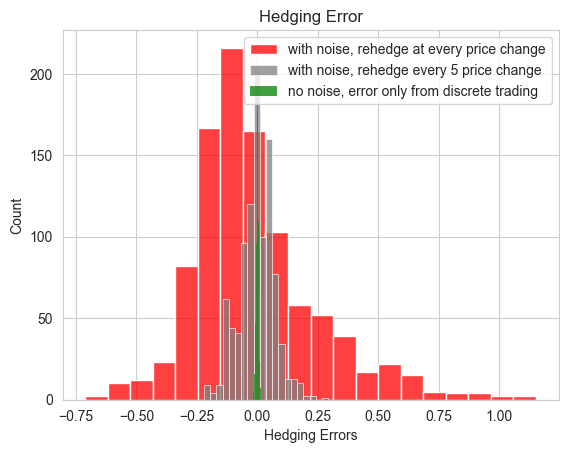

In [18]:
sns.histplot(error_2, label = "with noise, rehedge at every price change", bins = 20, color = 'red')
sns.histplot(error_3, label = f"with noise, rehedge every 5 price change", bins = 20, color='grey')
sns.histplot(error_1, label = "no noise, error only from discrete trading", bins = 20, color = 'green')

plt.xlabel("Hedging Errors")
plt.title("Hedging Error")
plt.legend()

<Axes: ylabel='Count'>

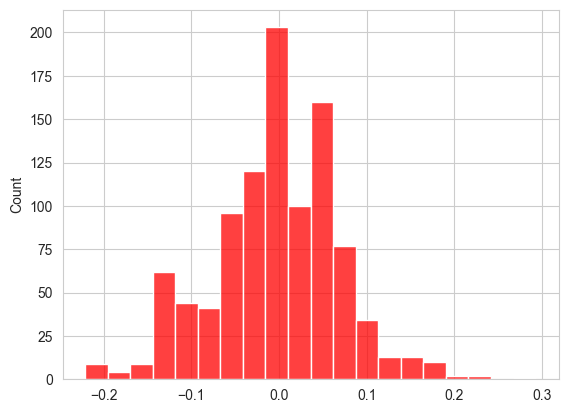

In [17]:
sns.histplot(error_3, label = "with noise, rehedge at every price change", bins = 20, color = 'red')
